
### Weather observations from Synoptic Weather 
Here, we demonstrate functions that download observation data from Synoptic Weather using the package `synopticpy`.

Our aim is to create straightforward API calls to download weather data for given radius, variables, times, etc. 

We should demonstrate visualizations of the data, both as a sanity check and for reports/publications.

Also:
* Show representative observation creation 
* More...

In [1]:
import os 
import datetime
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from synoptic.services import stations_timeseries

from obs.obsdata import ObsData
from viz import plotting


/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/synoptic/accessors.py:28: UserWarning: map making not available without Brian's cartopy_tools
  warnings.warn("map making not available without Brian's cartopy_tools")


In [2]:
def visualize_station_locations(meta_df, towns, extent, only_stids=None, stid_name=False):
    """
    Visualize station locations on a map.

    Args:
        meta_df (pd.DataFrame): Metadata dataframe containing station information.
        towns (dict): Dictionary of towns with their coordinates.
        extent (list): List of extents for the map [west, east, south, north].
        only_stids (list, optional): List of station IDs to plot. If None, plot all stations.
        stid_name (bool, optional): Annotate the stid string by each scatter point. Default is False.

    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.axes(projection=ccrs.PlateCarree())

    lats = []
    lons = []
    elevs = []
    stids = []

    for stid in meta_df.columns:
        if only_stids is None or stid in only_stids:
            # Convert to meters
            elevs.append(meta_df[stid].loc["ELEV_DEM"] * 0.304)
            lats.append(meta_df[stid].loc["latitude"])
            lons.append(meta_df[stid].loc["longitude"])
            stids.append(stid)

    sc = ax.scatter(lons, lats, c=elevs, transform=ccrs.PlateCarree())
    cbar = fig.colorbar(sc, orientation='horizontal', pad=0.01)

    # Annotate stid string by each scatter point if stid_name is True
    if stid_name:
        for lon, lat, stid in zip(lons, lats, stids):
            ax.text(lon, lat, stid, transform=ccrs.PlateCarree(), fontsize=8)

    # Add reference towns in RED
    for town, latlon in towns.items():
        ax.scatter(latlon[1], latlon[0], color='red', transform=ccrs.PlateCarree())
        ax.text(latlon[1], latlon[0], town, color='red', transform=ccrs.PlateCarree())

    ax.add_feature(cfeature.STATES.with_scale("10m"))
    ax.add_feature(cfeature.RIVERS.with_scale("10m"))

    ax.set_extent(extent)  # set extents
    plt.show()

In [3]:
def plot_variable_by_years(data_path, common_stids, years, vrbl, ylim=None):
    """
    Plot the variable by day of the year for each year, overlaying the lines for each winter season.

    Args:
        data_path (str): Path to the data files.
        common_stids (set): Set of common station IDs.
        years (list): List of years to plot.
        vrbl (str): Variable name to plot.

    Returns:
        None
    """
    fig, ax = plt.subplots(3, 3, figsize=(15, 15))
    plot_years = years[-5:]

    for i, stid in enumerate(common_stids):
        row = i // 3
        col = i % 3
        ax[row, col].set_title(stid)
        if ylim:
            ax[row, col].set_ylim(ylim)
        # Each "year" actually goes across two calendar years, so x-axis is 1 Dec to 31 March
        # The year is the February year of that particular subset

        for year in plot_years:
            df, meta_df = ObsData.load_dfs(data_path, f"UB_obs_{year}.parquet")
            df = df[df["stid"] == stid]
        
            # Filter to include only November to March
            df = df[(df.index.month >= 11) | (df.index.month <= 3)]
        
            df[vrbl].plot(ax=ax[row, col], label=year)
            
        # for a in ax.flat:
        #     a.set_xlim([pd.Timestamp('2000-11-01'), pd.Timestamp('2001-03-31')])

    # Add legend outside the plot
    fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

    plt.tight_layout()
    plt.show()


In [4]:
def compute_max_temp_profile(df, meta_df, target_date, timezone="US/Mountain"):
    """
    Compute the maximum temperature by station and day, and filter by a specific date.

    Args:
        df (pd.DataFrame): Original DataFrame with a datetime index and columns "stid" and "air_temp".
        meta_df (pd.DataFrame): Metadata DataFrame containing station information.
        target_date (str or pd.Timestamp): The target date to filter the results.
        timezone (str): The timezone to convert the DataFrame index to. Default is "US/Mountain".

    Returns:
        pd.DataFrame: DataFrame with maximum temperatures and elevations for the target date.
    """
    # Copy the dataframe for non-destructive playtime
    _df = df.copy(deep=True)[["stid", "air_temp"]]

    # Get dataframe into the specified timezone
    _df.index = _df.index.tz_convert(timezone)

    # Add a local_day column
    _df["local_day"] = _df.index.date

    # Ensure local_day is in datetime format
    _df["local_day"] = pd.to_datetime(_df["local_day"])

    # Group by 'stid' and 'local_day' to compute the maximum temperature
    max_temp = _df.groupby(["stid", "local_day"])["air_temp"].max().reset_index()
    max_temp = max_temp.rename(columns={"air_temp": "max_air_temp"})

    # Get elevations of the unique stations in max_temp in a dictionary
    elevations = {stid: meta_df[stid].loc["ELEV_DEM"] * 0.304 for stid in max_temp["stid"].unique()}

    # Filter to only those with the target date
    max_temp = max_temp[max_temp["local_day"] == pd.Timestamp(target_date)]

    # Add a column with the elevation of the station
    max_temp["elevation"] = max_temp["stid"].map(elevations)
    
    # Sort so elevation is ascending order.
    max_temp = max_temp.sort_values("elevation").dropna()

    return max_temp

In [5]:

def load_data_for_years(data_path, years, vrbl):
    """
    Load data for each year and count the number of unique stations that report at least one non-NaN for the given variable.

    Args:
        data_path (str): Path to the data files.
        years (list): List of years to load data for.
        vrbl (str): Variable name to check for non-NaN values.

    Returns:
        pd.DataFrame: DataFrame with counts of unique stations per year and their IDs.
    """
    year_counts = {}
    vrbl_stids = {}

    for year in years:
        df, meta_df = ObsData.load_dfs(data_path, f"UB_obs_{year}.parquet")
        
        try:
            small_df = df[[vrbl, "stid"]]
            year_counts[year] = small_df[small_df[vrbl].notnull()]["stid"].nunique()
            vrbl_stids[year] = small_df[small_df[vrbl].notnull()]["stid"].unique()
        except KeyError:
            print(f"Data for {year} not found")
            year_counts[year] = 0
            vrbl_stids[year] = []
            continue

    year_counts_df = pd.DataFrame.from_dict(year_counts, orient='index', columns=["stids"])
    stid_string_col = [",".join(vrbl_stids[year]) if len(vrbl_stids[year]) else "" for year in years]
    year_counts_df["stid_string"] = stid_string_col

    return year_counts_df

def find_common_stids(vrbl_stids, years, num_years):
    """
    Find the station IDs that have reported for the last `num_years` consistently.

    Args:
        vrbl_stids (dict): Dictionary of station IDs per year.
        years (list): List of years.
        num_years (int): Number of years to check for consistency.

    Returns:
        set: Set of common station IDs.
    """
    stids = [set(vrbl_stids[year]) for year in years[-num_years:]]
    return set.intersection(*stids)



In [6]:
def compute_pseudo_lapse_rate(filt_temp_df, elevations, x_range=(1000, 4000), do_filter=False, elev_bins=None, num_std_dev=1.5, do_plot=True):
    """
    Compute the pseudo-lapse rate using least squares regression and plot the results.

    Args:
        filt_temp_df (pd.DataFrame): DataFrame with the filtered temperature data.
        elevations (dict): Dictionary of station names and their elevations.
        x_range (tuple): Tuple of the x-axis range for the plot. Default is (1000, 4000).
        do_filter (bool): Whether to filter the temperature data. Default is False.
        elev_bins (list): List of elevation bins for filtering. Default is None.
        num_std_dev (float): Number of standard deviations to use for filtering. Default is 1.5.

    Returns:
        float: The computed slope of the regression line (pseudo-lapse rate) in °C/km.
    """
    if do_filter:
        assert elev_bins is not None
        filt_temp_df = ObsData.filter_temperature_outliers(filt_temp_df, elev_bins, num_std_dev=num_std_dev)
    
    # Compute the least squares regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(filt_temp_df["elevation"], filt_temp_df["max_air_temp"])

    # Print the slope in °C/km
    lapse_rate = slope * 1000
    print(f"Pseudo-lapse rate: {lapse_rate:.2f} °C/km")

    if do_plot:
        # Plot the profile
        fig, ax = plotting.plot_profile(filt_temp_df["max_air_temp"], filt_temp_df["elevation"], "obs", plot_levels=elevations)
    
        # Visualize the least squares regression as a line on the axes "ax"
        x = np.linspace(x_range[0], x_range[1], 100)
        y = slope * x + intercept
        ax.plot(y, x, color='black', linestyle='dashed')
        plt.show()

    return lapse_rate


In [7]:
# CONSTANTS
years = np.arange(2005,2025)


First section is commented out because we have already downloaded data using `download_gather_winters.py` script in the `obs` directory. It is kept to show the nature of the raw data and what was done to get to the ObsData class. The data has idiosyncracies like variable names containing "set" and "value". Note our metadata for each winter's forecast data is kept in a sister file (pickle, not parquet) denoted by the `_meta` suffix. 

### ALL DATA

In [8]:
# Test to look at example of the data of a bad year (2023)
df, meta_df = ObsData.load_dfs("../data", "UB_obs_2023.parquet")
df.head(10)

,air_temp,altimeter,ceiling,dew_point_temperature_set_1,dew_point_temperature,pressure,sea_level_pressure_set_1,sea_level_pressure,wind_direction,wind_speed,...,solar_radiation,dew_point_temperature_set_1d,soil_temp,soil_temp_set_2,soil_temp_set_3,soil_temp_set_4,soil_temp_set_5,NOx_concentration,ozone_concentration,PM_25_concentration
date_time,,,,,,,,,,,,,,,,,,,,,
2022-12-01 00:00:00+00:00,-5.0,101693.203125,NaN,NaN,-12.11,83777.976562,NaN,102371.351562,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:05:00+00:00,-3.0,101659.335938,NaN,NaN,-12.12,83750.093750,NaN,102188.390625,270.0,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:10:00+00:00,-3.0,101659.335938,NaN,NaN,-12.12,83750.093750,NaN,102188.390625,260.0,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:15:00+00:00,-3.0,101659.335938,NaN,NaN,-12.12,83750.093750,NaN,102188.390625,270.0,2.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:20:00+00:00,-4.0,101659.335938,NaN,NaN,-12.12,83750.093750,NaN,102262.531250,260.0,2.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:25:00+00:00,-7.0,101659.335938,NaN,NaN,-13.09,83750.093750,NaN,102488.578125,240.0,2.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:30:00+00:00,-6.0,101659.335938,NaN,NaN,-12.09,83750.093750,NaN,102412.609375,230.0,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:35:00+00:00,-7.0,101659.335938,NaN,NaN,-12.08,83750.093750,NaN,102488.562500,270.0,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:40:00+00:00,-6.0,101659.335938,NaN,NaN,-12.09,83750.093750,NaN,102412.609375,280.0,2.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Uncomment this to save some extracted data to a CSV file for easier upload/analysis via LLMs etc


In [9]:
# Perform the slicing operation
# sliced_df = df.sort_index().loc["2022-12-01":"2022-12-08"]

# Sort the DataFrame by the 'stid' column
# sorted_df = sliced_df.sort_values(by='stid')

# Save the sorted DataFrame to CSV
# sorted_df.to_csv("../data/2023_example.csv")


In [10]:
meta_df

,KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,...,4276P,PC266,PC353,UB1UT,PC486,UGSDV,UTELP,UTMTH,PC558,PC561
DISTANCE,20.26,22.29,40.84,32.16,39.04,37.87,37.27,42.98,34.35,21.18,...,26.36,25.48,16.98,15.51,29.22,15.57,17.01,40.08,23.64,30.35
ELEVATION,5262.0,5151.0,5725.0,9552.0,9448.0,7730.0,7484.0,6722.0,6469.0,5240.0,...,4803.0,8426.0,5947.0,5070.0,6149.0,5032.0,5692.0,6695.0,5818.0,5364.0
ELEV_DEM,5269.0,5200.1,5590.6,9583.3,9471.8,7729.7,7483.6,6702.8,6423.9,5226.4,...,NaN,8441.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ID,61,878,902,1494,1509,2336,2337,2348,2360,2365,...,173578,175633,217351,237823,238714,239856,243538,245316,245317,245375
MNET_ID,1,1005,19,25,25,2,2,2,2,2,...,208,247,247,153,247,153,4,4,247,247
NAME,Vernal Airport,ROOSEVELT-UNION HS,STARVATION DAM,MOSBY MTN.,TROUT CREEK,DIAMOND RIM,FIVE MILE,MCCOOK RIDGE,UPPER SAND WASH,YAMPA PLATEAU,...,Dino Ozone Station,Little Mountain,Vernal West,CIGE 226,Little Valley,Desert View (Myton) EC,SR-121 at MP 31.5 East Lapoint,SR-87 at MP 16 Mountain Home,Ashley,Duchesne River
RECORD_END,2024-10-10 08:45:00+00:00,2002-02-13 21:00:00+00:00,NaT,2024-10-10 08:00:00+00:00,2024-10-10 08:00:00+00:00,2024-10-10 08:27:00+00:00,2024-10-10 08:28:00+00:00,2024-10-10 08:27:00+00:00,2024-10-10 08:27:00+00:00,2024-10-10 08:27:00+00:00,...,2022-05-27 03:10:00+00:00,2024-10-10 08:40:00+00:00,2024-10-10 08:40:00+00:00,2024-10-10 08:15:00+00:00,2024-10-10 08:40:00+00:00,2024-10-10 08:30:00+00:00,2024-10-10 08:40:00+00:00,2024-10-10 08:40:00+00:00,2024-10-10 08:40:00+00:00,2024-10-10 08:40:00+00:00
RECORD_START,1997-01-01 00:00:00+00:00,1999-01-12 00:00:00+00:00,NaT,2000-01-20 00:00:00+00:00,2000-01-20 00:00:00+00:00,1997-01-01 00:00:00+00:00,1997-05-27 00:00:00+00:00,1997-01-01 00:00:00+00:00,1997-01-01 00:00:00+00:00,1997-01-01 00:00:00+00:00,...,2022-04-26 21:10:00+00:00,2022-06-30 20:15:00+00:00,2023-05-16 08:14:00+00:00,2024-05-13 18:00:00+00:00,2024-06-11 07:40:00+00:00,2024-07-12 19:30:00+00:00,2024-08-23 00:40:00+00:00,2024-09-26 20:40:00+00:00,2024-09-27 07:40:00+00:00,2024-10-03 07:30:00+00:00
RESTRICTED,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
STATE,UT,UT,UT,UT,UT,UT,UT,UT,UT,UT,...,UT,UT,UT,UT,UT,UT,UT,UT,UT,UT


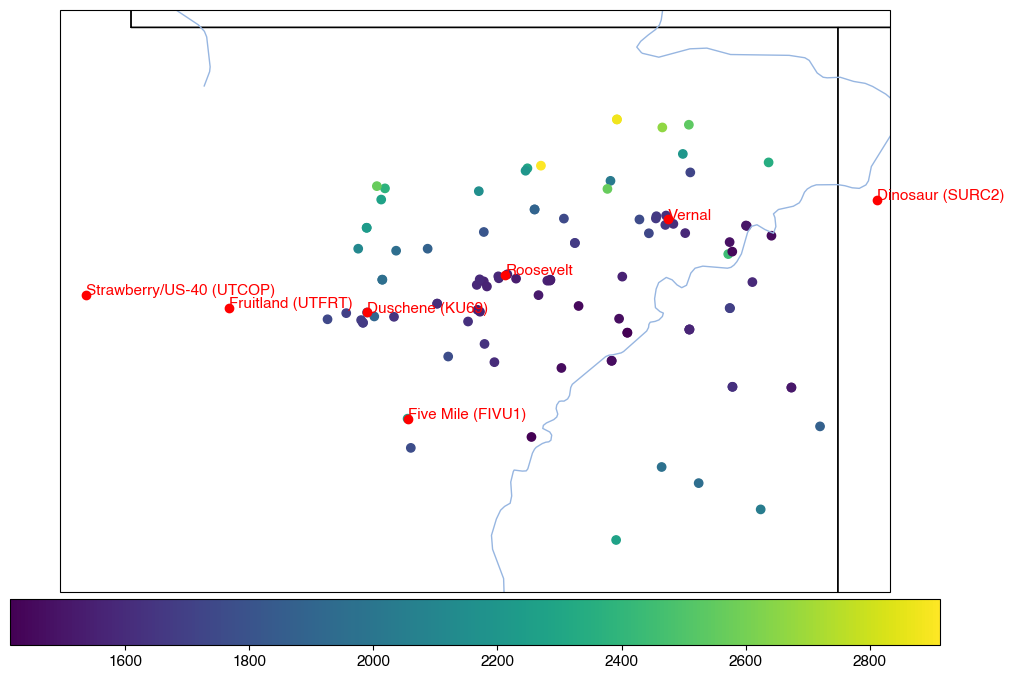

In [11]:

towns = {
    "Vernal": [40.4555, -109.5287],
    "Roosevelt": [40.2994, -109.9888],
    "Duschene (KU69)": [40.1919, -110.38099],
    "Fruitland (UTFRT)": [40.20525, -110.77125],
    "Strawberry/US-40 (UTCOP)": [40.2418, -111.1771],
    "Five Mile (FIVU1)": [39.89089, -110.266], 
    "Dinosaur (SURC2)": [40.51056, -108.93417],
}
extent = [-111.25, -108.9, 39.4, 41.05]

# Assuming meta_df is already defined
visualize_station_locations(meta_df, towns, extent)

### SOIL TEMPERATURE

In [12]:
# Subset df to columns containing "soil_temp".
soil_temp_cols = df.columns[df.columns.str.contains("soil_temp")]
soil_df = df[soil_temp_cols].dropna(how='all')
soil_df

,soil_temp,soil_temp_set_2,soil_temp_set_3,soil_temp_set_4,soil_temp_set_5
date_time,,,,,
2022-12-01 00:00:00+00:00,1.561,NaN,NaN,NaN,NaN
2022-12-01 00:10:00+00:00,1.561,NaN,NaN,NaN,NaN
2022-12-01 00:20:00+00:00,1.567,NaN,NaN,NaN,NaN
2022-12-01 00:30:00+00:00,1.572,NaN,NaN,NaN,NaN
2022-12-01 00:40:00+00:00,1.578,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-03-14 23:20:00+00:00,0.850,NaN,NaN,NaN,NaN
2023-03-14 23:30:00+00:00,0.967,NaN,NaN,NaN,NaN
2023-03-14 23:40:00+00:00,1.106,NaN,NaN,NaN,NaN


In [13]:
soil_df.describe()    

,soil_temp,soil_temp_set_2,soil_temp_set_3,soil_temp_set_4,soil_temp_set_5
count,143650.000000,29812.000000,9844.000000,9844.000000,9844.000000
mean,0.404829,0.071335,-0.247610,1.220378,3.100581
std,1.275590,1.297789,1.307646,0.867148,1.095681
min,-17.778000,-17.778000,-3.889000,-0.556000,1.111000
25%,-0.189000,-0.556000,-1.111000,0.556000,2.222000
50%,0.611000,0.556000,-0.556000,1.667000,3.333000
75%,1.361000,1.056000,1.111000,1.667000,3.333000
max,16.261000,1.444000,1.667000,3.333000,7.222000


In [14]:
data_path = "../data"
vrbl = "soil_temp"

year_counts_df = load_data_for_years(data_path, years, vrbl)
print(year_counts_df)

vrbl_stids = {year: year_counts_df.loc[year, "stid_string"].split(",") for year in years}
common_stemp_stids = find_common_stids(vrbl_stids, years, 5)
print(len(common_stemp_stids))
common_stemp_stids

Data for 2005 not found
      stids                                        stid_string
2005      0                                                   
2006      2                                        USWU1,SFLU1
2007      2                                        USWU1,SFLU1
2008     85  USWU1,SFLU1,MHMU1,AT569,A1388,A1633,A1622,A138...
2009     86  USWU1,SFLU1,UTSTV,MHMU1,AT569,A1388,A1633,A162...
2010     86  USWU1,SFLU1,UTSTV,MHMU1,AT569,A1388,A1633,A162...
2011      5                      USWU1,SFLU1,UTSTV,AS290,WAXU1
2012      5                      USWU1,SFLU1,UTSTV,AS290,WAXU1
2013      5                      USWU1,SFLU1,UTSTV,AS290,WAXU1
2014      5                      USWU1,SFLU1,UTSTV,AS290,WAXU1
2015      3                                  UTSTV,AS290,WAXU1
2016      3                                  UTSTV,AS290,WAXU1
2017      4                            UTSTV,AS290,WAXU1,UCC33
2018      9  UTSTV,AS290,WAXU1,MHMU1,AT569,SPMU1,LRFU1,UCC3...
2019      9  UTSTV,AS290,WAXU1,

{'AS290',
 'AT569',
 'LRFU1',
 'MHMU1',
 'SPMU1',
 'UCC33',
 'UCC34',
 'UTSTV',
 'WAXU1'}

### Tests for soil temperature: is there a relationship between snowfall and soil temperature, considering all years?
A warmer ground on Dec 1 may mean longer predictability for whether snow persists. 

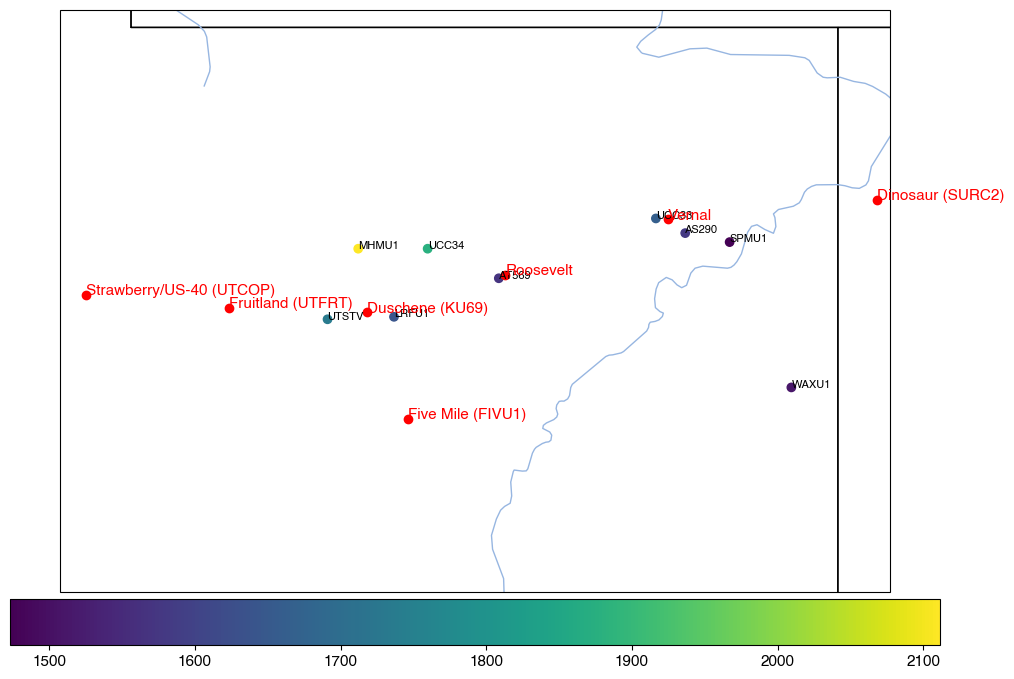

In [15]:
# Plot these common stids on a map, labelled.
visualize_station_locations(meta_df, towns, extent, only_stids=list(common_stemp_stids), stid_name=True)


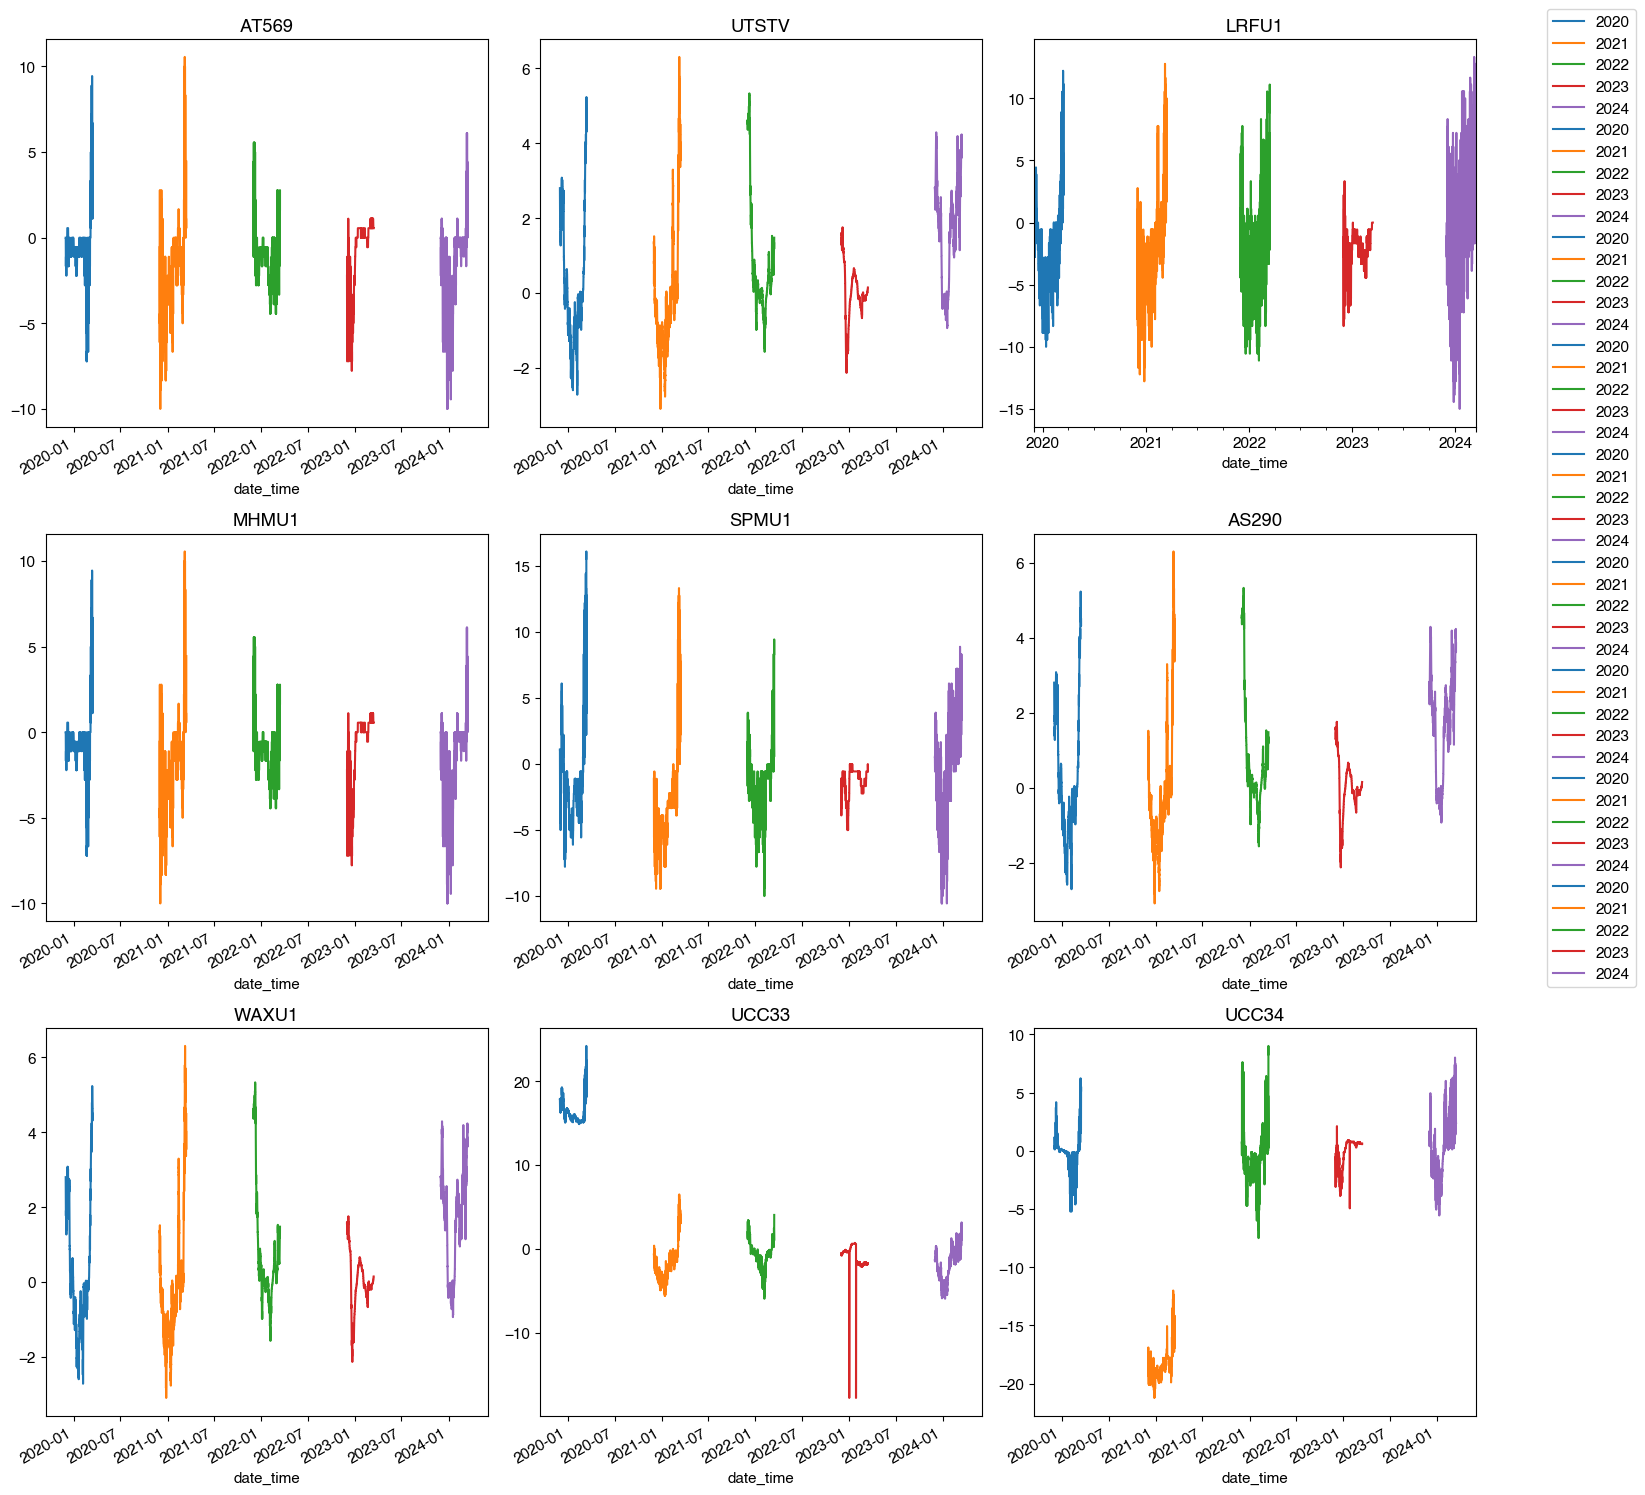

In [16]:
plot_variable_by_years(data_path, common_stemp_stids, years[-5:], vrbl)


### OZONE CONCENTRATION

In [17]:
vrbl = "ozone_concentration"

year_counts_df = load_data_for_years(data_path, years, vrbl)
print(year_counts_df)

vrbl_stids = {year: year_counts_df.loc[year, "stid_string"].split(",") for year in years}
common_ozone_stids = find_common_stids(vrbl_stids, years, 9)
print(len(common_ozone_stids))
common_ozone_stids

Data for 2005 not found
Data for 2006 not found
Data for 2007 not found
Data for 2008 not found
Data for 2009 not found
Data for 2010 not found
Data for 2011 not found
Data for 2012 not found
Data for 2013 not found
Data for 2014 not found
      stids                                        stid_string
2005      0                                                   
2006      0                                                   
2007      0                                                   
2008      0                                                   
2009      0                                                   
2010      0                                                   
2011      0                                                   
2012      0                                                   
2013      0                                                   
2014      0                                                   
2015      0                                                   
2016

{'A3822',
 'QRS',
 'QV4',
 'UBHSP',
 'UBMYT',
 'UBORY',
 'UBRBM',
 'UBRDW',
 'UBWHR',
 'UUT01'}

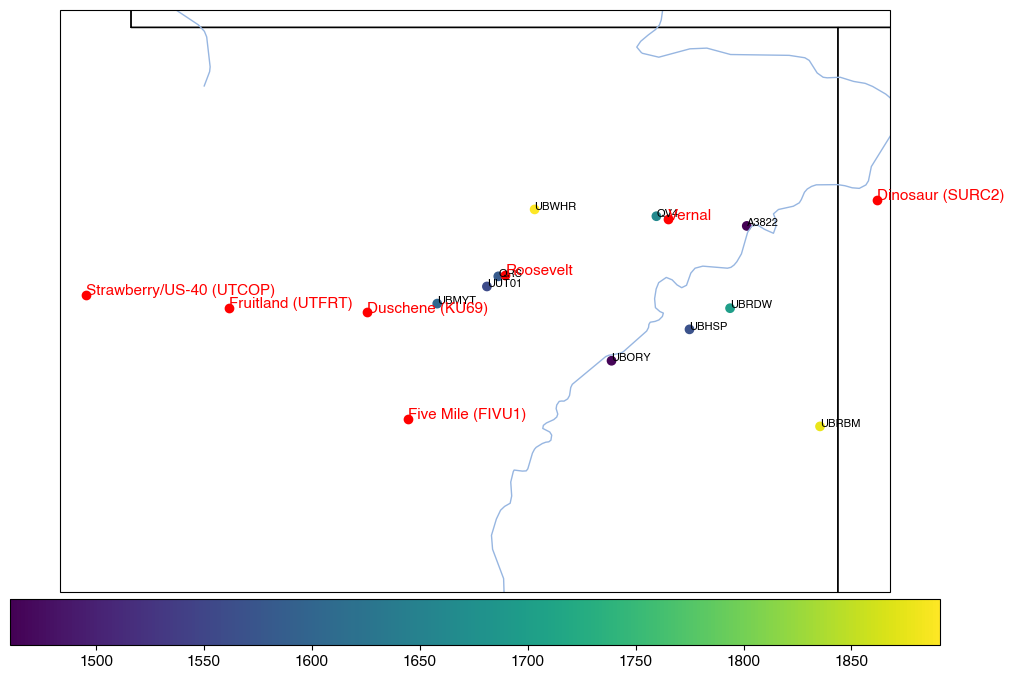

In [18]:
# Plot these common stids on a map, labelled.
visualize_station_locations(meta_df, towns, extent, only_stids=list(common_ozone_stids), stid_name=True)


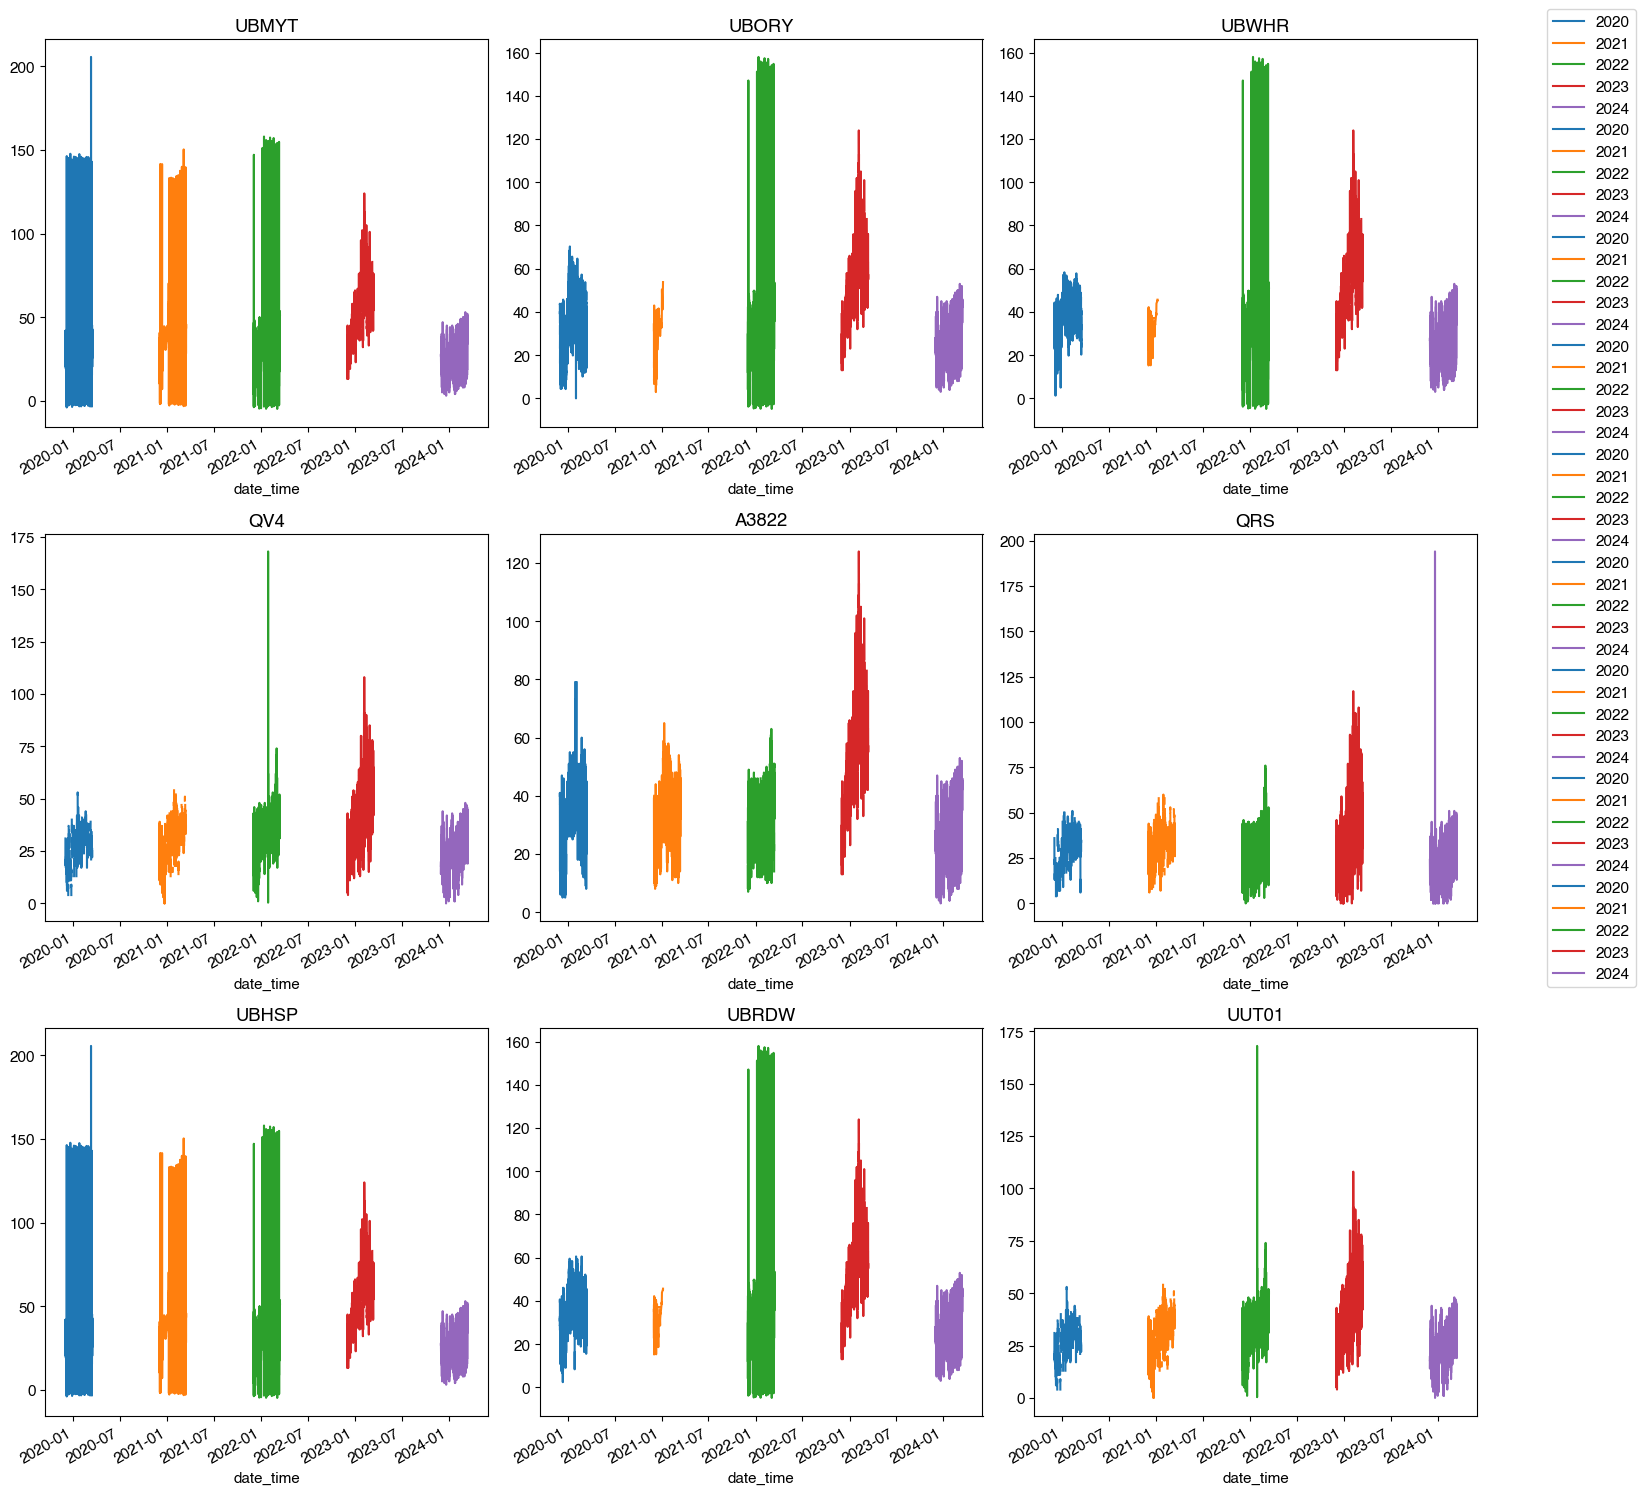

In [19]:
ozone_stids = [stid for stid in common_ozone_stids if "UBRB" not in stid]
plot_variable_by_years(data_path, ozone_stids, years[-5:], "ozone_concentration")


#### Filtering and QC of time series


 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=UBHSP&start=202112010000&end=202204010000&qc_remove_data=on&qc_checks=all&token=🙈HIDDEN



<Axes: xlabel='date_time'>

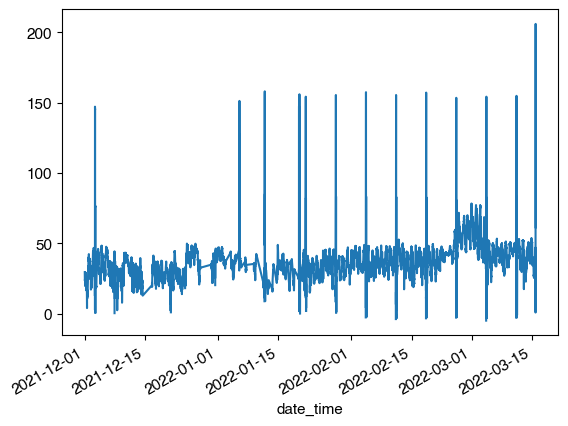

In [20]:
# Filtering function to remove esp. 2022 noise.
# QV4 QRS (Vernal and Roosevelt).
# Horsepool, 7S, Ouray tends to be bad! Needs filtering  - quality control? 1, 2, 3

# Let's try downloading data for UBHSP, Dec 2021, and see if we can filter it and check QC codes
# df_qc = stations_timeseries(stid='UBHSP', start=datetime.datetime(2021,12,1), end=datetime.datetime(2022,1,1))
df_qc = stations_timeseries(stid='UBHSP', start=datetime.datetime(2021,12,1), end=datetime.datetime(2022,4,1), qc_remove_data="on", qc_checks="all")
# df_qc = stations_timeseries(stid='UBHSP', start=datetime.datetime(2021,12,1), end=datetime.datetime(2022,1,1), qc_checks='all')
# df_qc = stations_timeseries(stid='UBHSP', start=datetime.datetime(2021,12,1), end=datetime.datetime(2022,1,1), qc_checks='synopticlabs')

# Plot the ozone_concentration for UBHSP - looks like anything over 140 should be NaN.
df_qc["ozone_concentration"].plot()

<Axes: xlabel='date_time'>

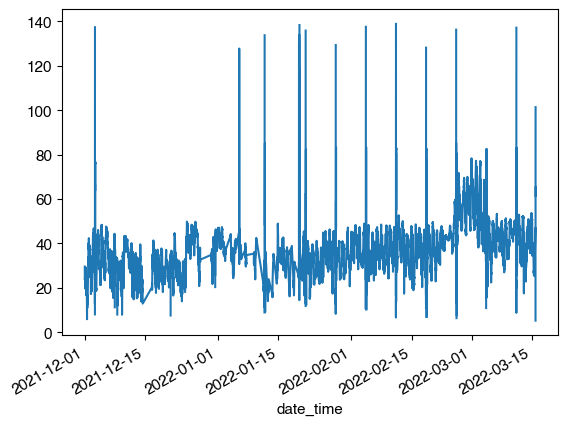

In [21]:
# Set values > 140 in df_qc for UBHSP (Horsepool) set to NaN.
df_qc.loc[df_qc["ozone_concentration"] > 140, "ozone_concentration"] = np.nan
df_qc.loc[df_qc["ozone_concentration"] < 5, "ozone_concentration"] = np.nan
df_qc["ozone_concentration"].plot()



 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=QV4&start=202112010000&end=202204010000&qc_remove_data=on&qc_checks=all&token=🙈HIDDEN



<Axes: xlabel='date_time'>

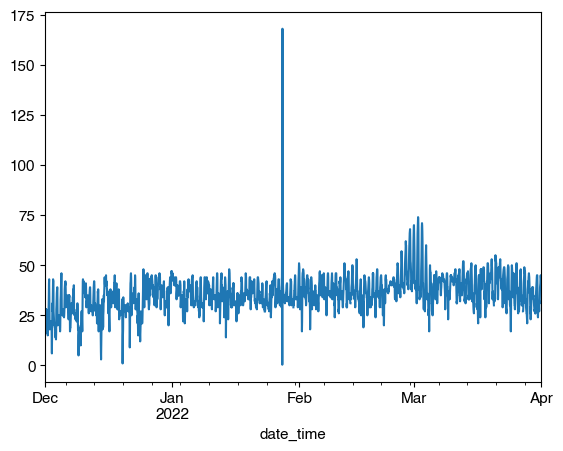

In [22]:
df_qc = stations_timeseries(stid='QV4', start=datetime.datetime(2021,12,1), end=datetime.datetime(2022,4,1), qc_remove_data="on", qc_checks="all")
df_qc["ozone_concentration"].plot()



 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=QRS&start=202112010000&end=202204010000&qc_remove_data=on&qc_checks=all&token=🙈HIDDEN



<Axes: xlabel='date_time'>

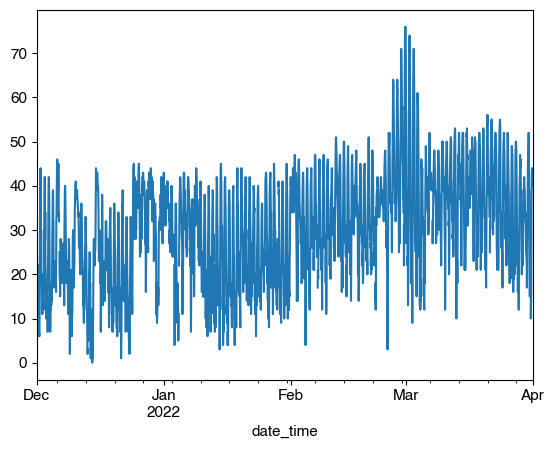

In [23]:
df_qc = stations_timeseries(stid='QRS', start=datetime.datetime(2021,12,1), end=datetime.datetime(2022,4,1), qc_remove_data="on", qc_checks="all")
df_qc["ozone_concentration"].plot()



 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=A3822&start=202112010000&end=202204010000&qc_remove_data=on&qc_checks=all&token=🙈HIDDEN



<Axes: xlabel='date_time'>

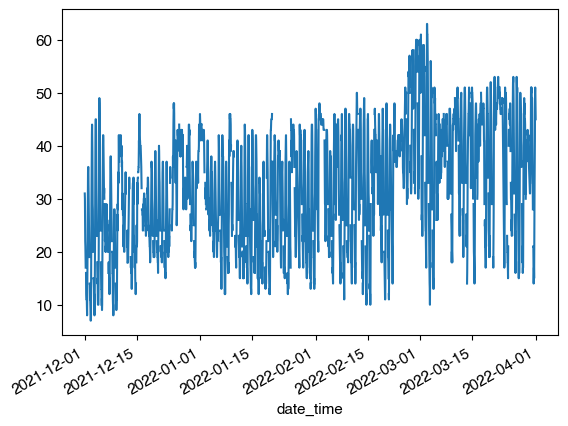

In [24]:
df_qc = stations_timeseries(stid='A3822', start=datetime.datetime(2021,12,1), end=datetime.datetime(2022,4,1), qc_remove_data="on", qc_checks="all")
df_qc["ozone_concentration"].plot()


### SNOW DEPTH

In [25]:
vrbl = "snow_depth"

year_counts_df = load_data_for_years(data_path, years, vrbl)
print(year_counts_df)

vrbl_stids = {year: year_counts_df.loc[year, "stid_string"].split(",") for year in years}
common_snow_stids = find_common_stids(vrbl_stids, years, 8)
print(len(common_snow_stids))
common_snow_stids

      stids                                        stid_string
2005      3                                  MMTU1,TCKU1,KGCU1
2006      3                                  MMTU1,TCKU1,KGCU1
2007      3                                  MMTU1,TCKU1,KGCU1
2008      3                                  MMTU1,TCKU1,KGCU1
2009      3                                  MMTU1,TCKU1,KGCU1
2010      3                                  MMTU1,TCKU1,KGCU1
2011      3                                  MMTU1,TCKU1,KGCU1
2012      4                            MMTU1,TCKU1,KGCU1,LFKU1
2013      4                            MMTU1,TCKU1,KGCU1,LFKU1
2014      4                            MMTU1,TCKU1,KGCU1,LFKU1
2015      4                            MMTU1,TCKU1,KGCU1,LFKU1
2016      6                MMTU1,TCKU1,KGCU1,LFKU1,TRZO3,UBHSP
2017     15  MMTU1,TCKU1,KGCU1,LFKU1,TRZO3,UBHSP,COOPALMU1,...
2018     17  MMTU1,TCKU1,KGCU1,LFKU1,TRZO3,UBHSP,UBMTH,COOP...
2019     35  MMTU1,TCKU1,KGCU1,LFKU1,UBHSP,UBMTH,UBMYT,

{'COOPALMU1',
 'COOPDINU1',
 'COOPDSNU1',
 'COOPFTDU1',
 'COOPJENU1',
 'COOPNELU1',
 'COOPOURU1',
 'COOPROSU1',
 'COOPVELU1',
 'KGCU1',
 'LFKU1',
 'MMTU1',
 'TCKU1'}

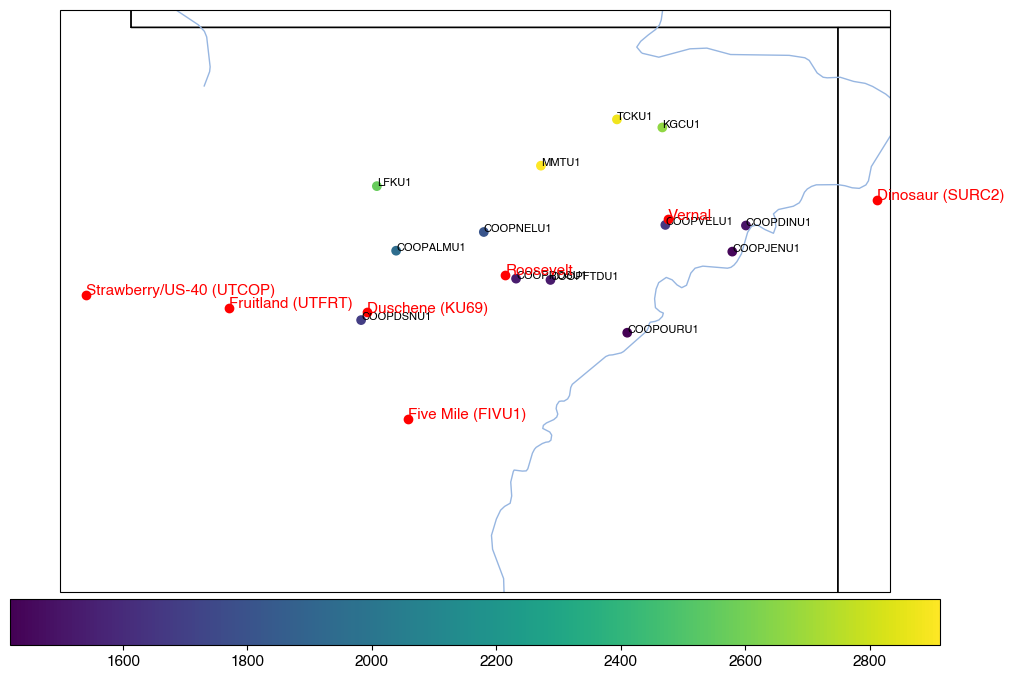

In [26]:
visualize_station_locations(meta_df, towns, extent, only_stids=list(common_snow_stids), stid_name=True)


In [27]:
snow_stids = [stid for stid in common_snow_stids if "COOP" in stid]
snow_stids

['COOPOURU1',
 'COOPDINU1',
 'COOPVELU1',
 'COOPROSU1',
 'COOPFTDU1',
 'COOPJENU1',
 'COOPALMU1',
 'COOPNELU1',
 'COOPDSNU1']

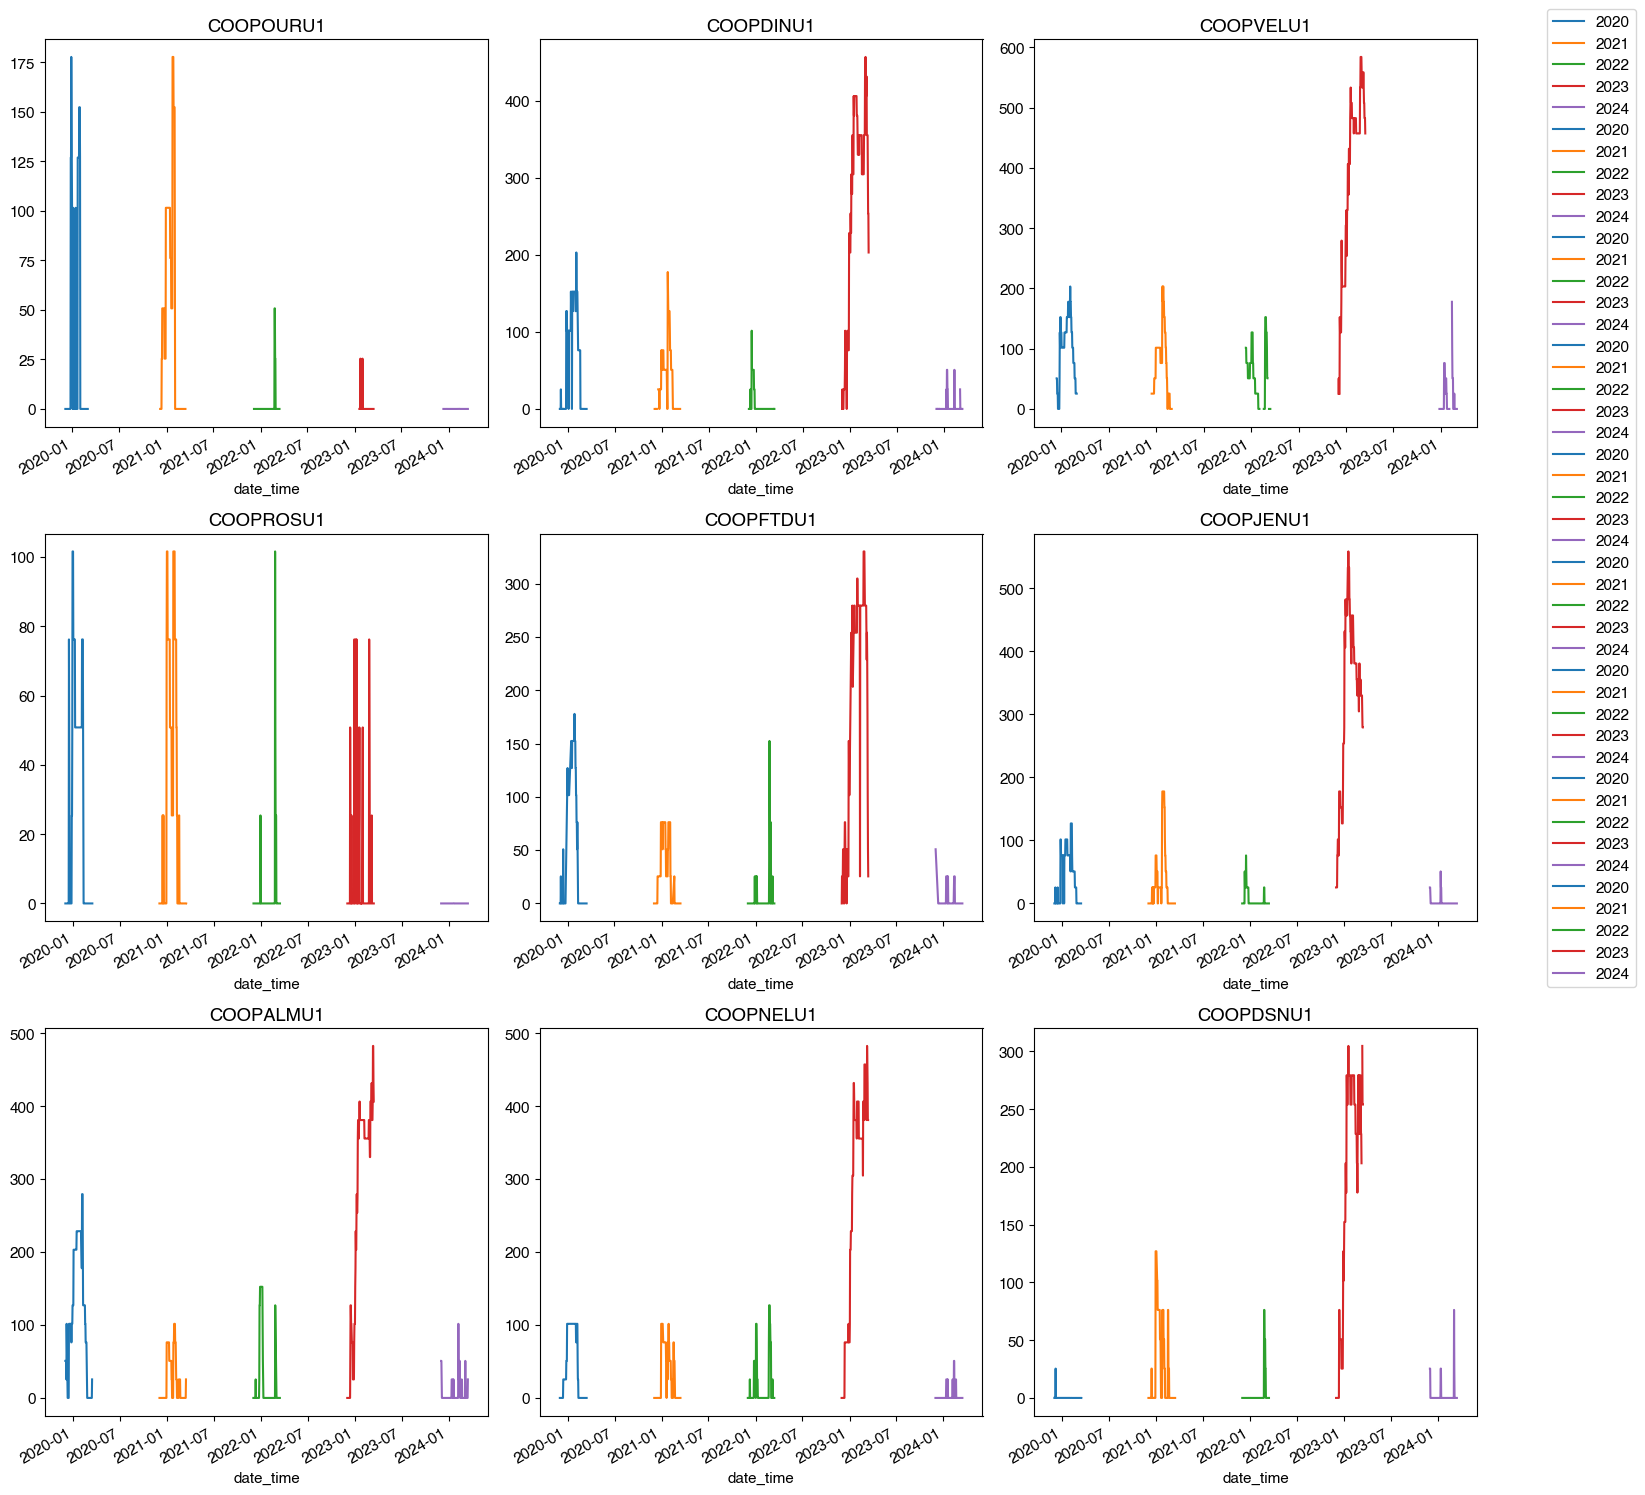

In [28]:
# Now visualise with the plot of 3x3 stations for snow depth 
plot_variable_by_years(data_path, snow_stids, years[-8:], vrbl)

In [29]:
# How to reduce? Take the 99th percentile of all reports within the local day

### WIND SPEED

In [30]:
vrbl = "wind_speed"

year_counts_df = load_data_for_years(data_path, years, vrbl)
print(year_counts_df)

vrbl_stids = {year: year_counts_df.loc[year, "stid_string"].split(",") for year in years}
common_wind_stids = find_common_stids(vrbl_stids, years, 10)
print(len(common_wind_stids))
common_wind_stids

      stids                                        stid_string
2005     12  KVEL,RSVL,CUPH,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,Y...
2006    100  KVEL,RSVL,CUPH,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,Y...
2007     19  KVEL,RSVL,CUPH,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,Y...
2008    100  KVEL,RSVL,CUPH,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,Y...
2009    100  KVEL,RSVL,CUPH,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,Y...
2010    100  KVEL,RSVL,CUPH,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,Y...
2011     99  KVEL,RSVL,CUPH,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,Y...
2012     98  KVEL,RSVL,CUPH,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,Y...
2013     97  KVEL,RSVL,CUPH,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,Y...
2014     92  KVEL,RSVL,CUPH,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,Y...
2015     41  KVEL,RSVL,CUPH,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,Y...
2016     91  KVEL,RSVL,CUPH,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,Y...
2017     53  KVEL,RSVL,CUPH,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,Y...
2018     59  KVEL,RSVL,CUPH,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,Y...
2019     58  KVEL,RSVL,CUPH,DIAU1,FIVU1,MCKU1,USWU1,SFL

{'A1386',
 'A1388',
 'A1622',
 'A1633',
 'AS290',
 'BRUU1',
 'C4620',
 'CUPH',
 'DIAU1',
 'DURU1',
 'E3712',
 'E8302',
 'FIVU1',
 'K74V',
 'KU67',
 'KU69',
 'KU71',
 'KVEL',
 'LRFU1',
 'MCKU1',
 'MYT5',
 'NUTU1',
 'QRS',
 'QV4',
 'RSVL',
 'SFLU1',
 'SPMU1',
 'UB7ST',
 'UFD07',
 'UINU1',
 'USWU1',
 'UTSTV',
 'UUT01',
 'WATU1',
 'WAXU1',
 'YLLU1',
 'YLSU1'}

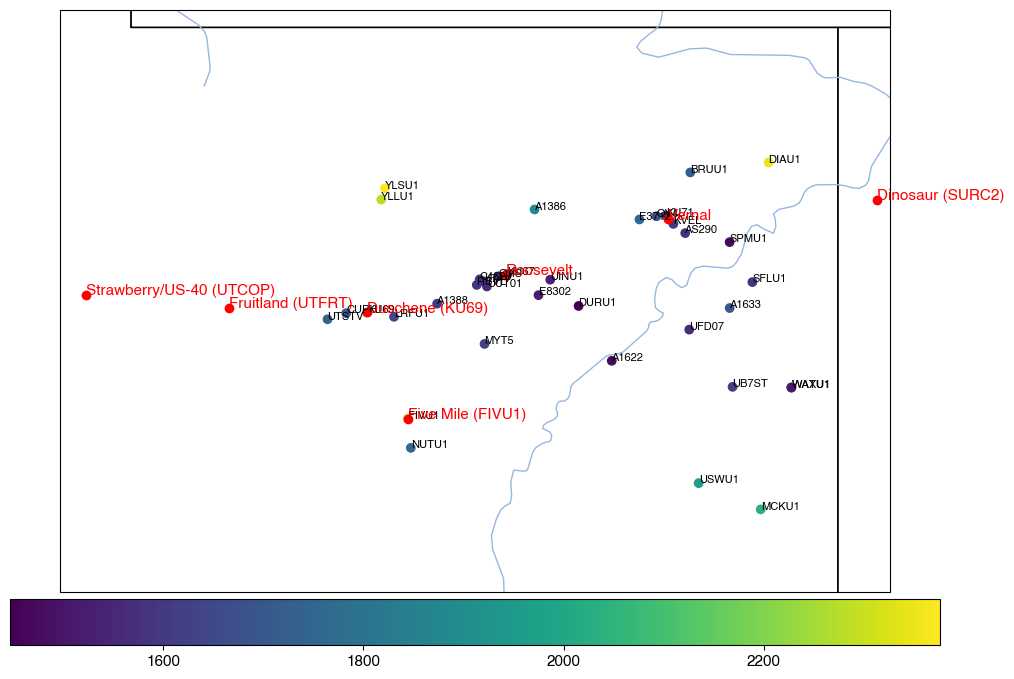

In [31]:
visualize_station_locations(meta_df, towns, extent, only_stids=list(common_wind_stids), stid_name=True)

In [32]:
# Metadata for the stations contains elevation as "ELEVATION".
# Find the nine lowest stations in common_wind_stids.
elevations = [meta_df[stid].loc["ELEV_DEM"] for stid in common_wind_stids]
sorted_wind_stids = [stid for _, stid in sorted(zip(elevations, common_wind_stids))][:9]

# Replace some bad stations with good 
bad_stid = ["UINU1", "KU67", "WATU1", "UUT01"]
add_stid = ["KVEL", "QRS", "QV4", "MYT5"]

# Replace the two bad with the two good 
sorted_wind_stids = [stid if stid not in bad_stid else add_stid[bad_stid.index(stid)] for stid in sorted_wind_stids]
sorted_wind_stids

['DURU1', 'A1622', 'SPMU1', 'QV4', 'WAXU1', 'E8302', 'KVEL', 'QRS', 'MYT5']

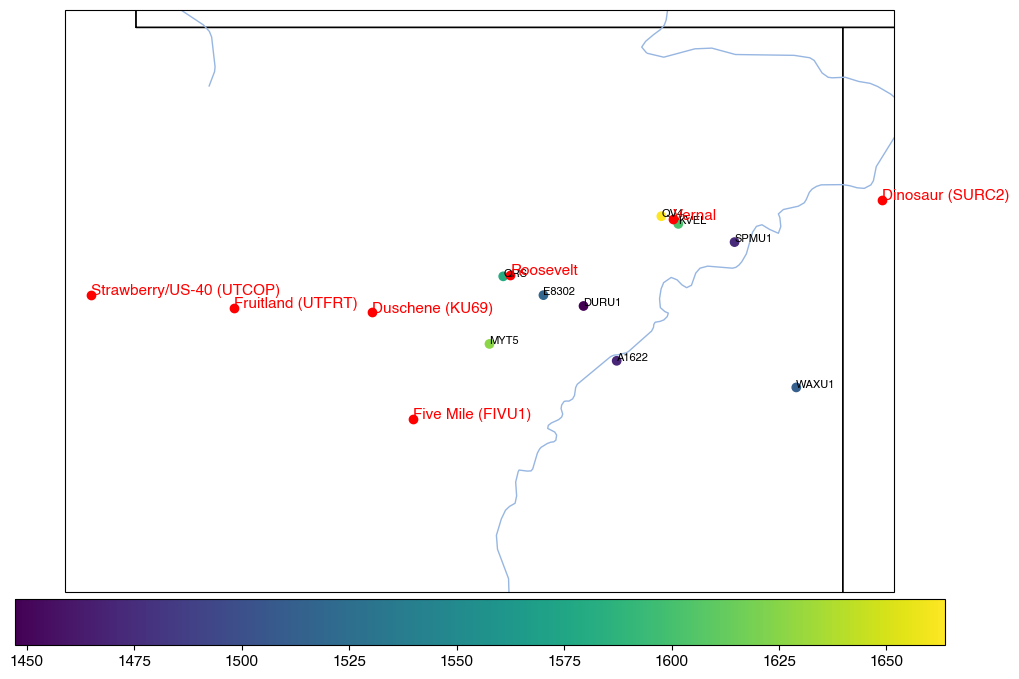

In [33]:
visualize_station_locations(meta_df, towns, extent, only_stids=list(sorted_wind_stids), stid_name=True)

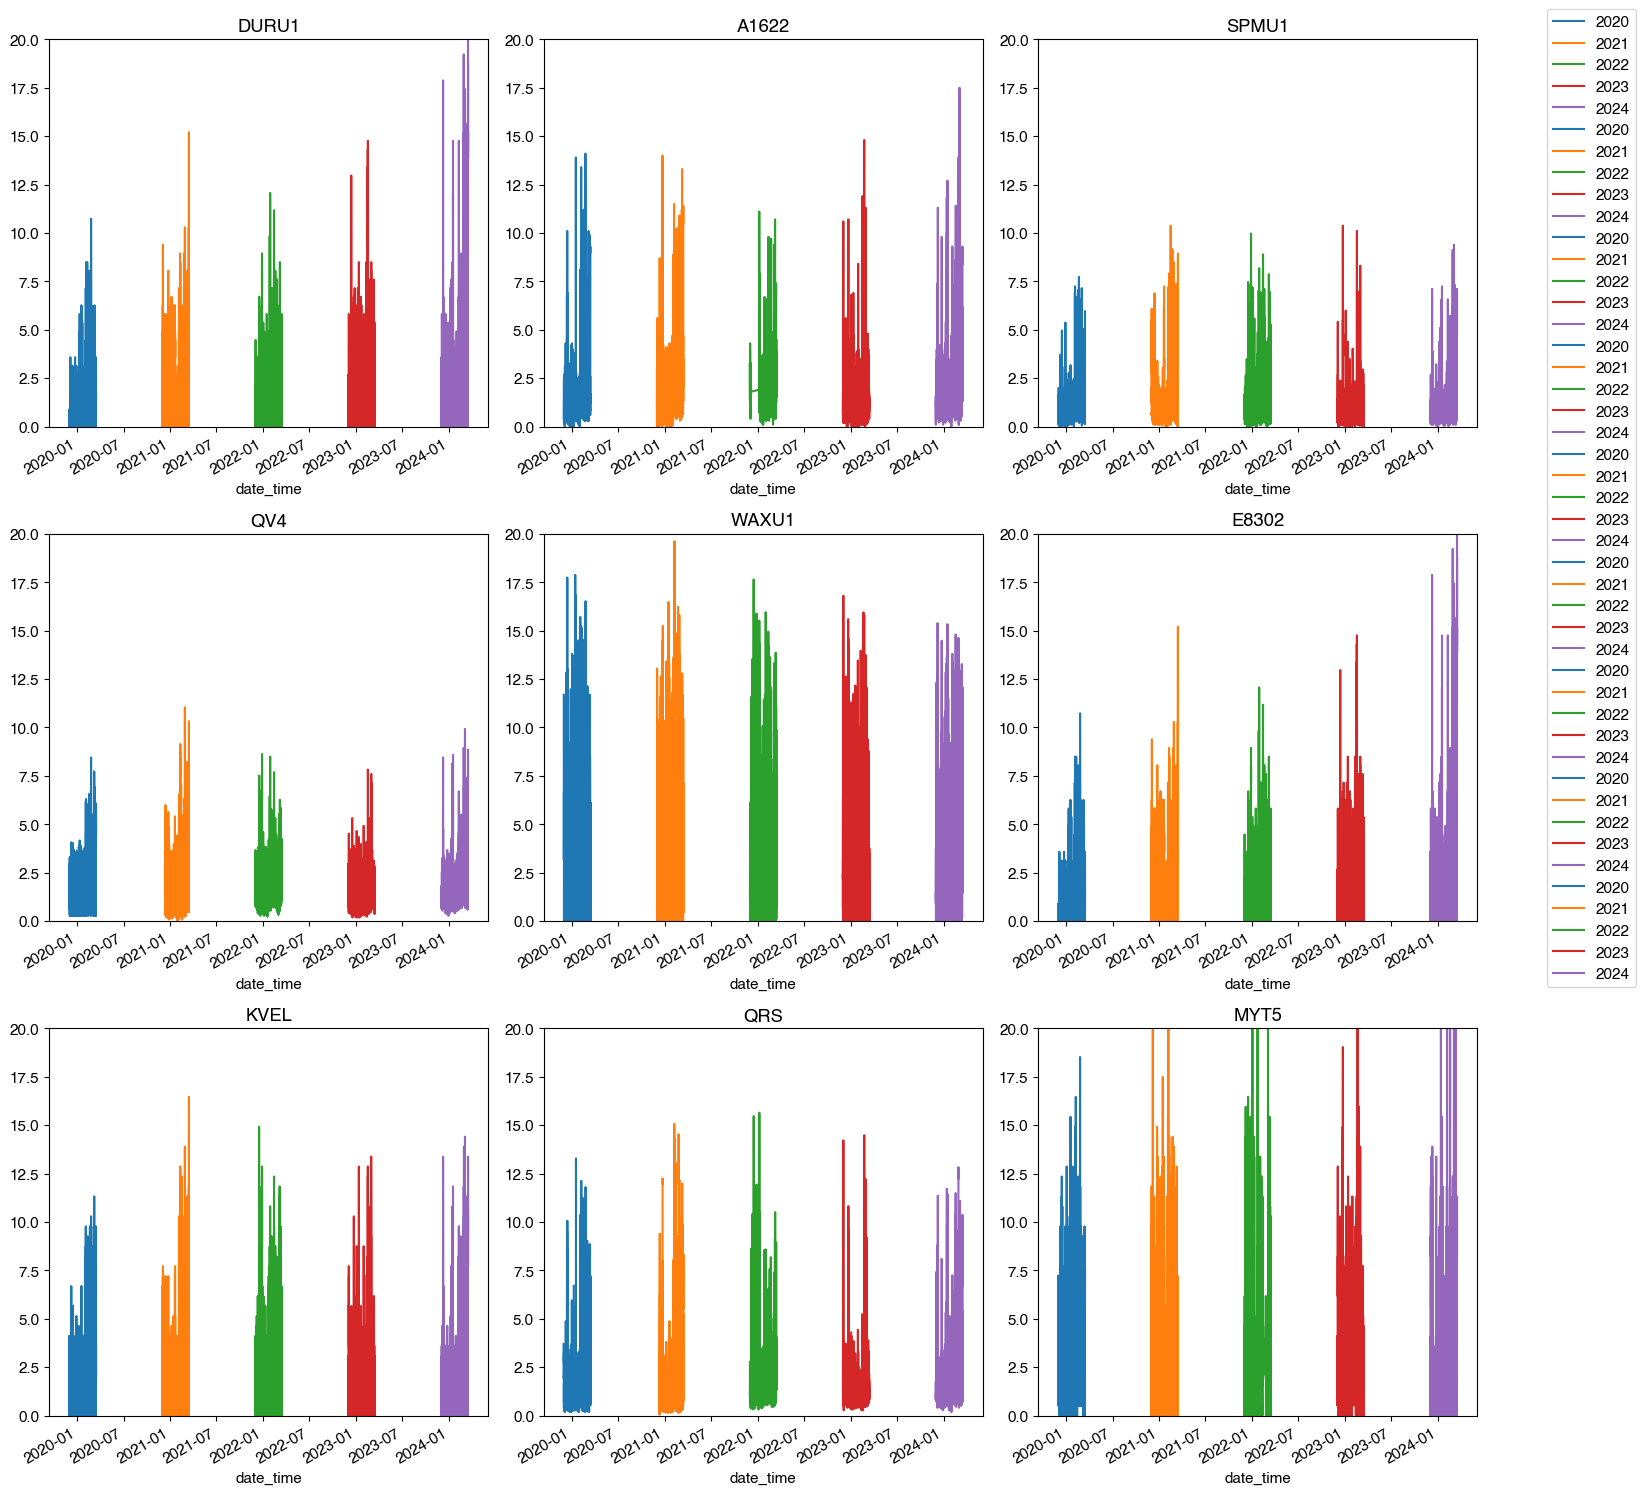

In [34]:
# Now visualise with the plot of 3x3 stations for snow depth 
plot_variable_by_years(data_path, sorted_wind_stids, years[-5:], vrbl, ylim=[0, 20])

### SOLAR RADIATION

In [35]:
vrbl = "solar_radiation"

year_counts_df = load_data_for_years(data_path, years, vrbl)
print(year_counts_df)

vrbl_stids = {year: year_counts_df.loc[year, "stid_string"].split(",") for year in years}
common_solar_stids = find_common_stids(vrbl_stids, years, 10)
print(len(common_solar_stids))
common_solar_stids

      stids                                        stid_string
2005      7          DIAU1,FIVU1,MCKU1,USWU1,SFLU1,YLSU1,UINU1
2006      7          DIAU1,FIVU1,MCKU1,USWU1,SFLU1,YLSU1,UINU1
2007      7          DIAU1,FIVU1,MCKU1,USWU1,SFLU1,YLSU1,UINU1
2008     90  DIAU1,FIVU1,MCKU1,USWU1,SFLU1,YLSU1,UINU1,MHMU...
2009     90  DIAU1,FIVU1,MCKU1,USWU1,SFLU1,YLSU1,UINU1,MHMU...
2010     90  DIAU1,FIVU1,MCKU1,USWU1,SFLU1,YLSU1,UINU1,MHMU...
2011     88  DIAU1,FIVU1,MCKU1,USWU1,SFLU1,YLSU1,UINU1,MHMU...
2012     14  DIAU1,FIVU1,MCKU1,USWU1,SFLU1,YLSU1,UINU1,MHMU...
2013     17  DIAU1,FIVU1,MCKU1,USWU1,SFLU1,YLSU1,UINU1,UTST...
2014     16  DIAU1,FIVU1,MCKU1,USWU1,SFLU1,YLSU1,UINU1,UTST...
2015     26  DIAU1,FIVU1,MCKU1,USWU1,SFLU1,YLSU1,UINU1,UTST...
2016     69  DIAU1,FIVU1,MCKU1,USWU1,SFLU1,YLSU1,UINU1,UTST...
2017     31  DIAU1,FIVU1,MCKU1,USWU1,SFLU1,YLSU1,UINU1,UTST...
2018     37  DIAU1,FIVU1,MCKU1,USWU1,SFLU1,YLSU1,UINU1,UTST...
2019     44  DIAU1,FIVU1,MCKU1,USWU1,SFLU1,YLSU1,UINU1,

{'A1386',
 'A1388',
 'A1622',
 'A1633',
 'AS290',
 'BRUU1',
 'DIAU1',
 'DURU1',
 'E3712',
 'FIVU1',
 'LRFU1',
 'MCKU1',
 'MHMU1',
 'SFLU1',
 'SPMU1',
 'UFD07',
 'UINU1',
 'USWU1',
 'UTSTV',
 'WATU1',
 'WAXU1',
 'YLLU1',
 'YLSU1'}

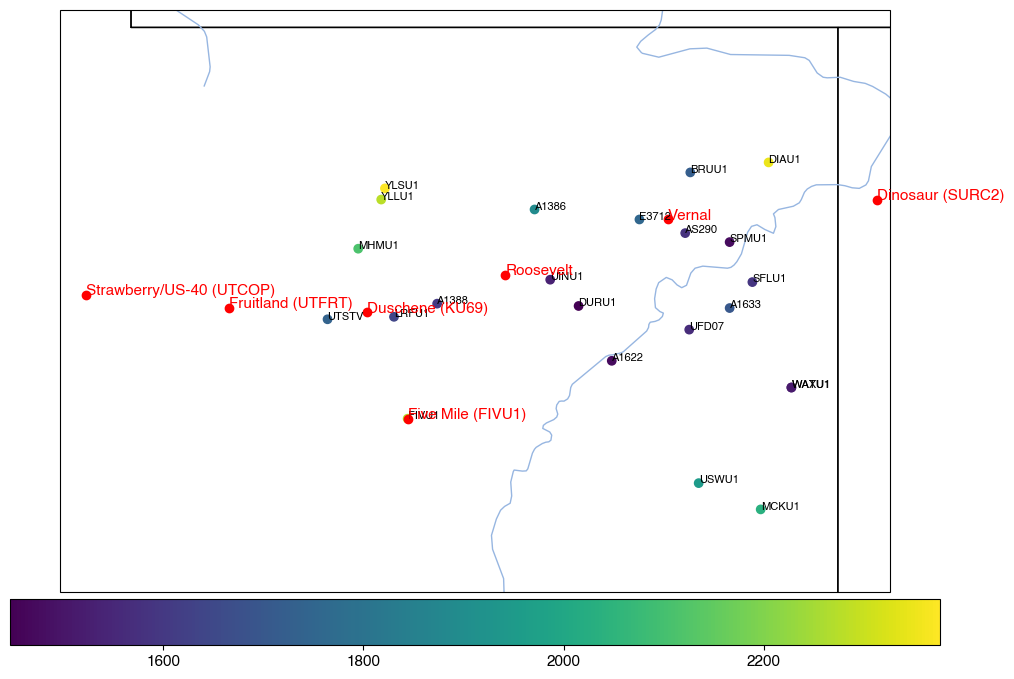

In [36]:
visualize_station_locations(meta_df, towns, extent, only_stids=list(common_solar_stids), stid_name=True)

In [37]:
elevations = [meta_df[stid].loc["ELEV_DEM"] for stid in common_solar_stids]
sorted_solar_stids = [stid for _, stid in sorted(zip(elevations, common_solar_stids))][:9]

# Replace some bad stations with good 
# bad_stid = ["E3712","KU67"]
# add_stid = []

# Replace the two bad with the two good 
# sorted_wind_stids = [stid if stid not in bad_stid else add_stid[bad_stid.index(stid)] for stid in sorted_wind_stids]

sorted_solar_stids


['DURU1',
 'A1622',
 'SPMU1',
 'WATU1',
 'WAXU1',
 'UINU1',
 'UFD07',
 'AS290',
 'SFLU1']

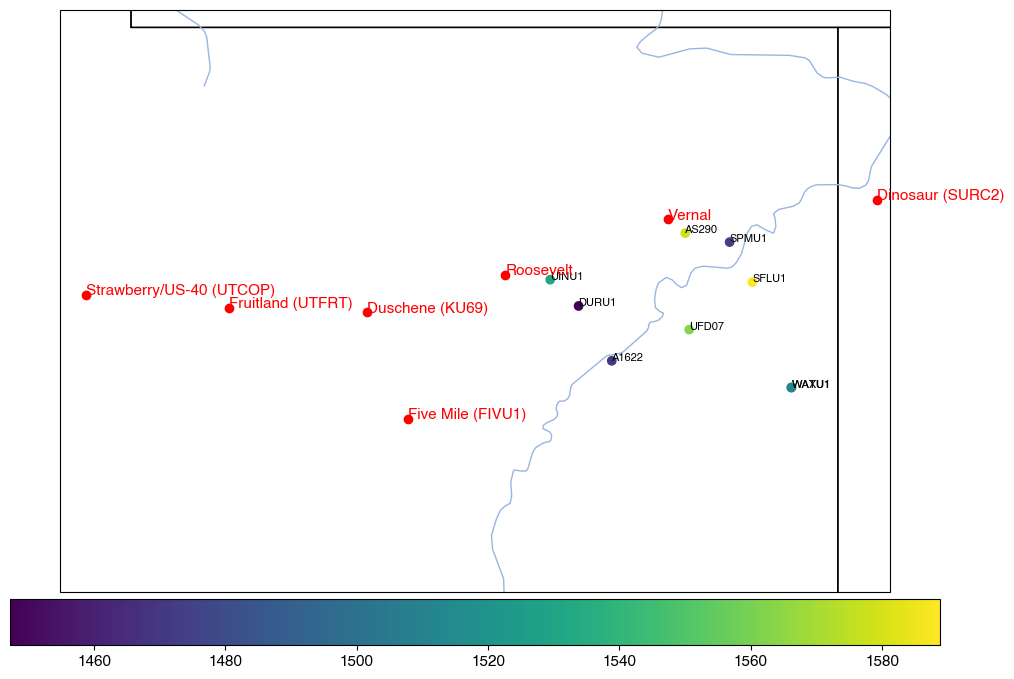

In [38]:
visualize_station_locations(meta_df, towns, extent, only_stids=list(sorted_solar_stids), stid_name=True)

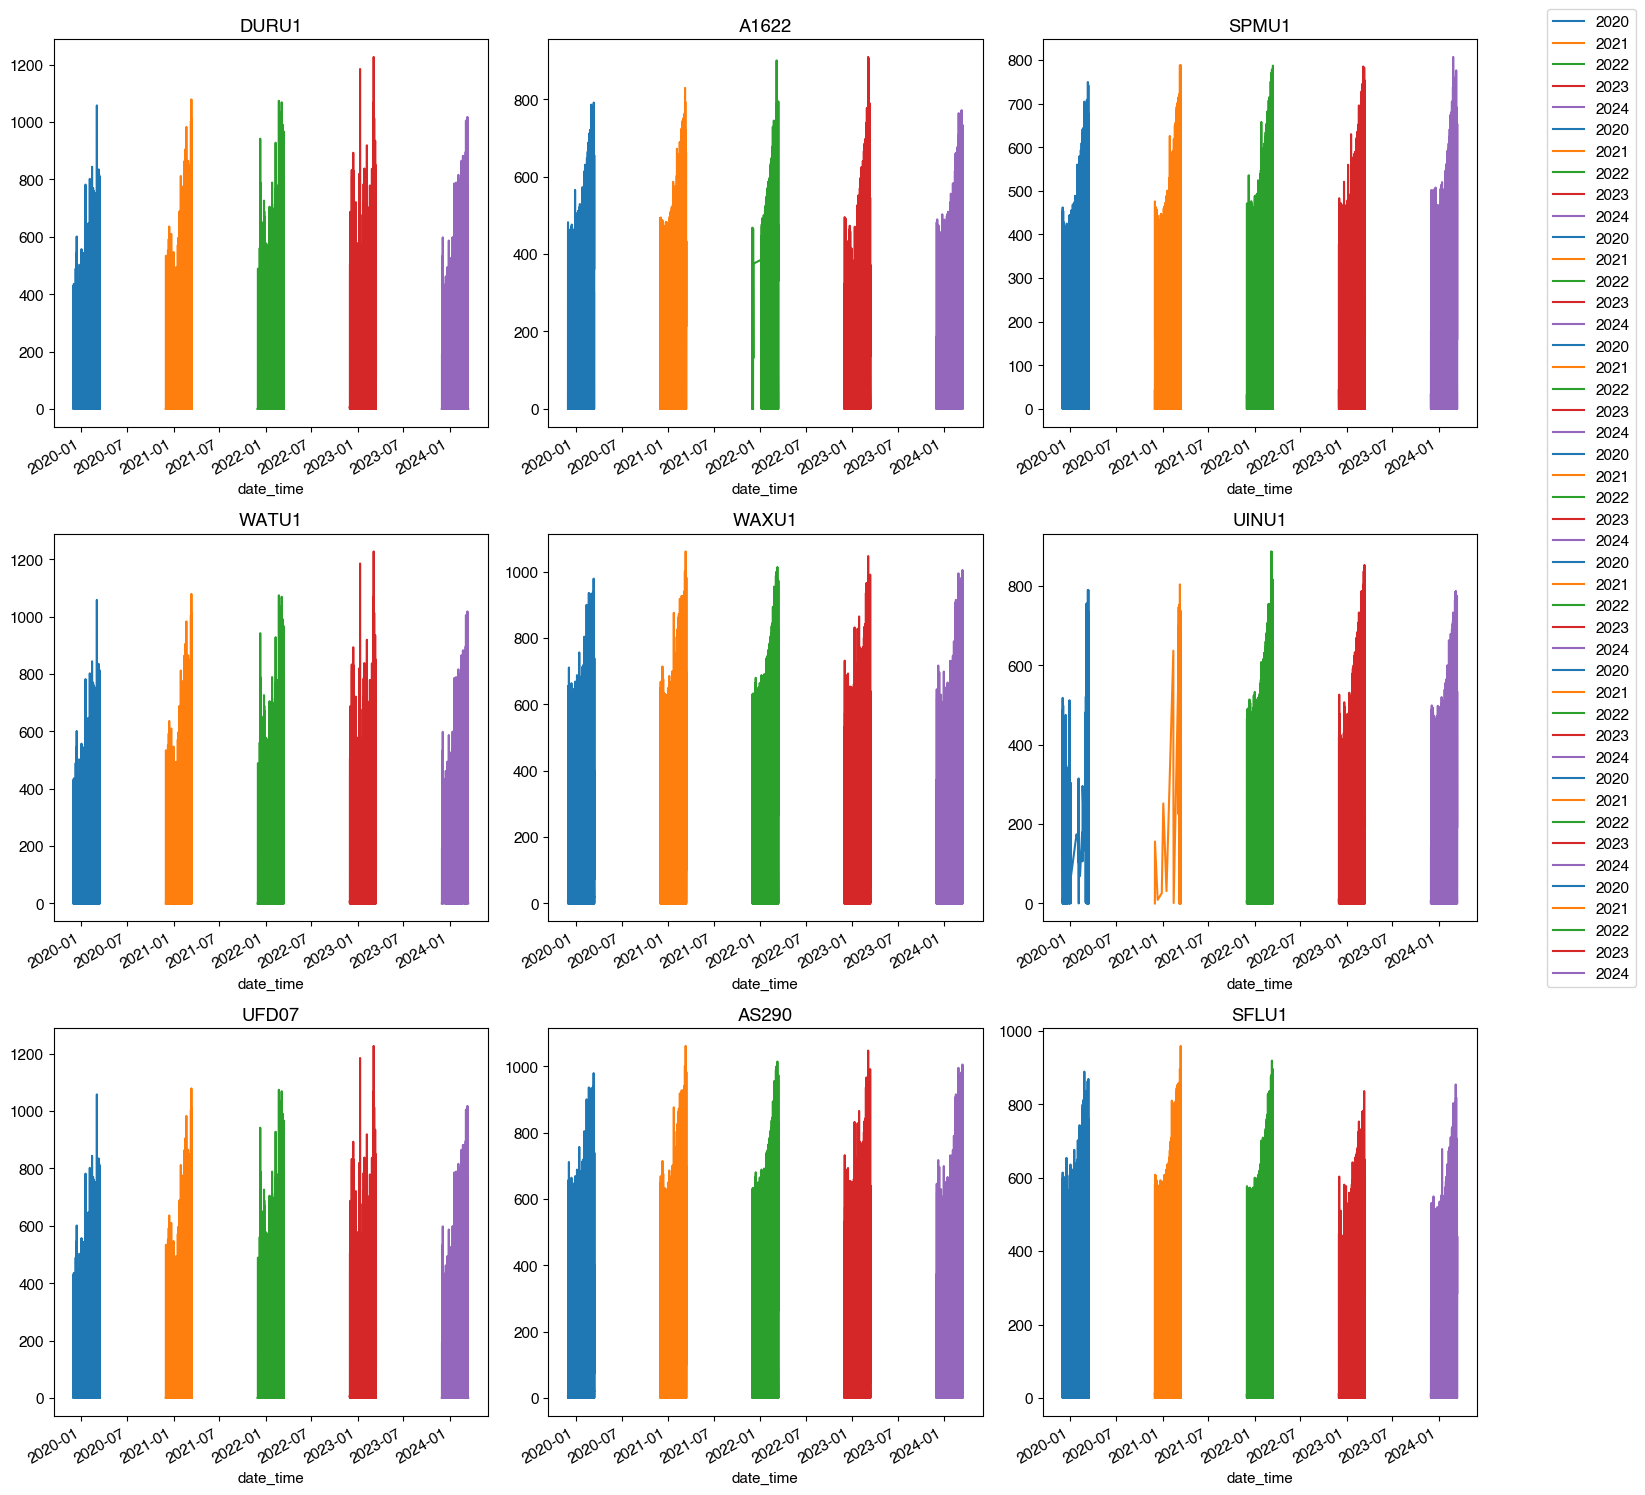

In [39]:
plot_variable_by_years(data_path, sorted_solar_stids, years[-5:], vrbl)
# Best: [DURU1, A1622, SPMU1, WAXU1] 

### Pseudo lapse rate
We can estimate a lapse rate of temperature using the variation of observed temperature with elevation, meaning we can use the station's altitude to compute potential temperature and therefore stability and presence of inversions.

In [40]:
vrbl = "air_temp"

year_counts_df = load_data_for_years(data_path, years, vrbl)
print(year_counts_df)

vrbl_stids = {year: year_counts_df.loc[year, "stid_string"].split(",") for year in years}
common_temp_stids = find_common_stids(vrbl_stids, years, 3)
print(len(common_temp_stids))
common_temp_stids

      stids                                        stid_string
2005    108  KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,U...
2006    108  KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,U...
2007    108  KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,U...
2008    108  KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,U...
2009    108  KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,U...
2010    108  KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,U...
2011    108  KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,U...
2012    108  KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,U...
2013    108  KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,U...
2014    108  KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,U...
2015     56  KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,U...
2016    107  KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,U...
2017     80  KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,U...
2018     83  KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,U...
2019     83  KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCK

{'4276P',
 'A1386',
 'A1388',
 'A1622',
 'A1633',
 'A3822',
 'AS290',
 'AT569',
 'BRUU1',
 'C4620',
 'COOPALMU1',
 'COOPDINU1',
 'COOPDSNU1',
 'COOPFTDU1',
 'COOPJENU1',
 'COOPMYTU1',
 'COOPROSU1',
 'COOPVELU1',
 'CUPH',
 'DIAU1',
 'DURU1',
 'E3712',
 'E8302',
 'FIVU1',
 'JESU1',
 'K74V',
 'KGCU1',
 'KU67',
 'KU69',
 'KU71',
 'KVEL',
 'LFKU1',
 'LRFU1',
 'MCKU1',
 'MHMU1',
 'MMTU1',
 'MYT5',
 'NUTU1',
 'PC101',
 'PC266',
 'PC353',
 'PC486',
 'PC558',
 'PC561',
 'QRS',
 'QV4',
 'RSVL',
 'SFLU1',
 'SPMU1',
 'TCKU1',
 'TR383',
 'TRZO3',
 'UB1UT',
 'UB7ST',
 'UBCSP',
 'UBDRF',
 'UBFDU',
 'UBFLR',
 'UBHSP',
 'UBMTH',
 'UBMYT',
 'UBORY',
 'UBRBM',
 'UBRDW',
 'UBWHR',
 'UCC33',
 'UCC34',
 'UCL13',
 'UCL21',
 'UCL22',
 'UFD07',
 'UGSDV',
 'UINU1',
 'URHSC',
 'USU01',
 'USU02',
 'USU03',
 'USU04',
 'USU05',
 'USU06',
 'USU07',
 'USU08',
 'USWU1',
 'UTASH',
 'UTBAS',
 'UTELP',
 'UTMTH',
 'UTMYT',
 'UTSTV',
 'UTVU1',
 'UTWPO',
 'UUT01',
 'WATU1',
 'WAXU1',
 'WHRU1',
 'WTRU1',
 'YLLU1',
 'YLSU1'}

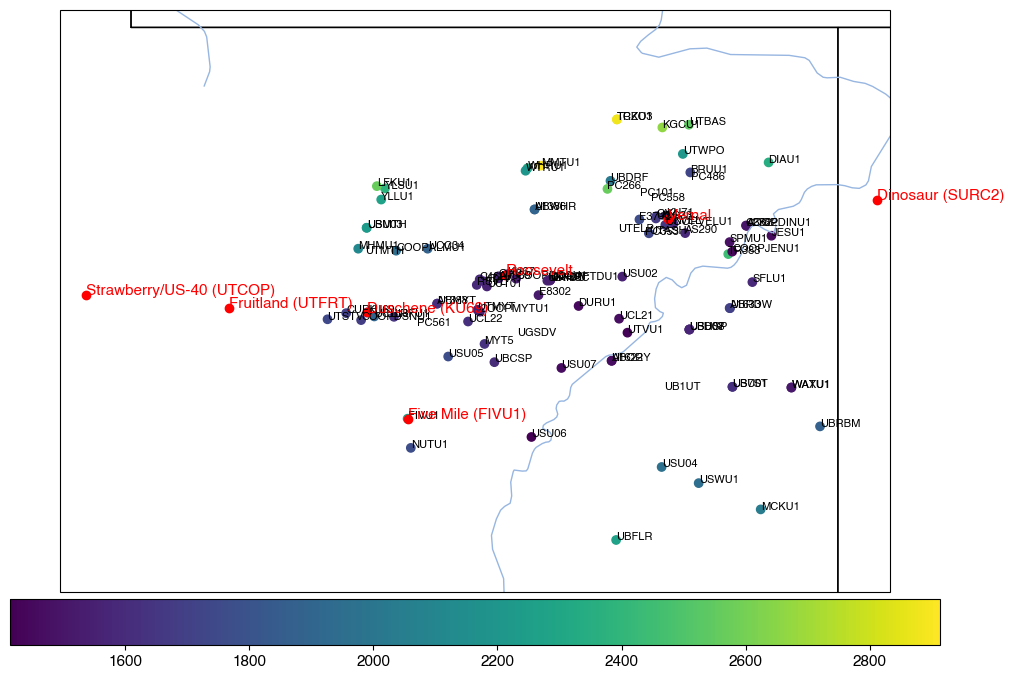

In [41]:
visualize_station_locations(meta_df, towns, extent, only_stids=list(common_temp_stids), stid_name=True)

In [42]:
# For the data, subset the dataframe to those with stid in common_temp_stids
common_temp_df = df[df["stid"].isin(common_temp_stids)]
max_temp_20221201 = compute_max_temp_profile(common_temp_df, meta_df, "2022-12-01")
max_temp_20221201

,stid,local_day,max_air_temp,elevation
8177,USU06,2022-12-01,35.571999,1414.2688
9206,UTVU1,2022-12-01,-3.528000,1421.2608
1442,COOPJENU1,2022-12-01,-4.444000,1439.2272
2023,DURU1,2022-12-01,2.778000,1447.1920
2443,JESU1,2022-12-01,-1.900000,1453.1808
...,...,...,...,...
3153,LFKU1,2022-12-01,1.000000,2566.2464
2650,KGCU1,2022-12-01,-0.200000,2662.9792
5240,TRZO3,2022-12-01,2.778000,2879.4272
5031,TCKU1,2022-12-01,-1.400000,2879.4272


## Sensitivity to filtering out weird temperature values
Some of this is due to error. Some is from unrepresentative stations included in the dataset.

Pseudo-lapse rate: 0.16 °C/km


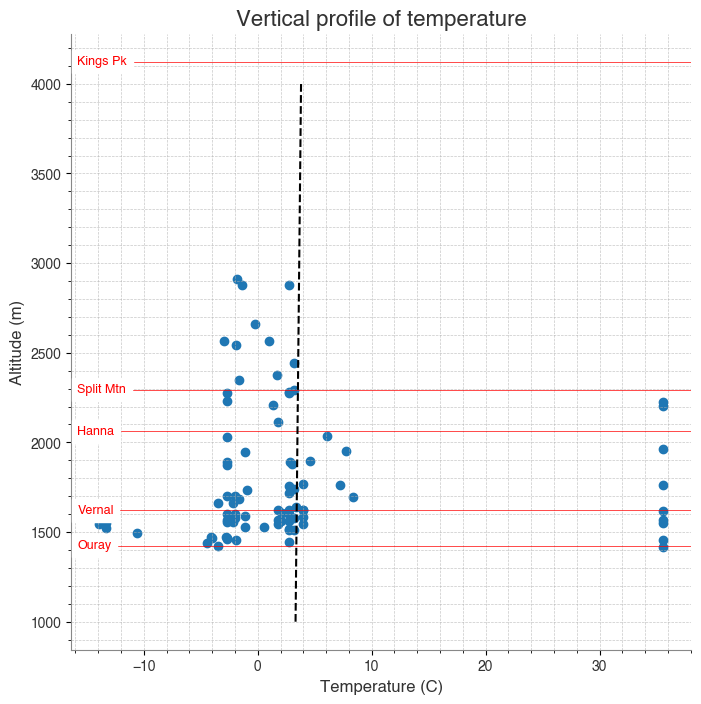

In [43]:
# Example usage
elevations = {
    "Ouray": 1425,
    "Vernal": 1622,
    "Hanna": 2062,
    "Split Mtn": 2294,
    "Kings Pk": 4123,
}

elev_bins = np.arange(1000, 4001, 250)

# No filtering 
lapse_rate = compute_pseudo_lapse_rate(max_temp_20221201, elevations, do_filter=False)

Pseudo-lapse rate: 4.02 °C/km


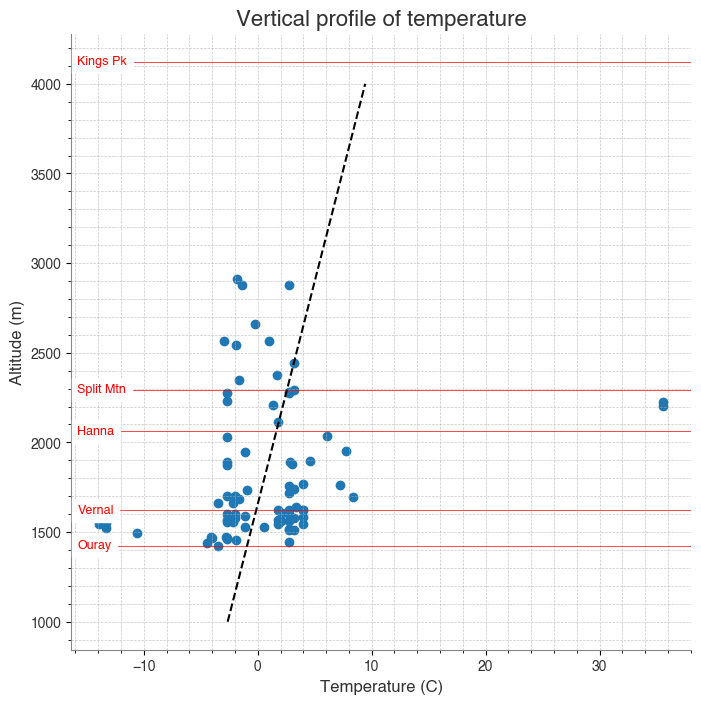

In [44]:
# With filtering at 1 standard dev
lapse_rate = compute_pseudo_lapse_rate(max_temp_20221201, elevations, do_filter=True, elev_bins=elev_bins, num_std_dev=2)

Pseudo-lapse rate: 3.70 °C/km


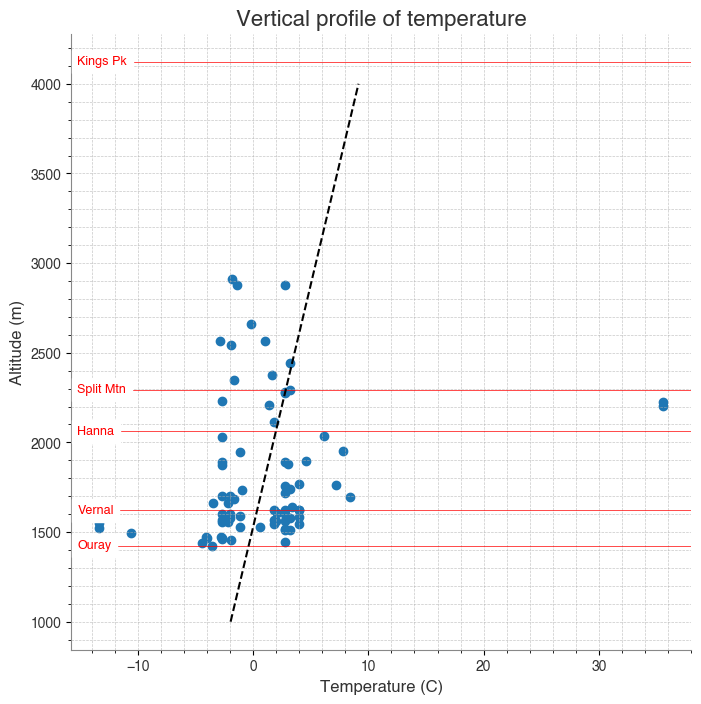

In [45]:
# With filtering at 1.5 standard dev
lapse_rate = compute_pseudo_lapse_rate(max_temp_20221201, elevations, do_filter=True, elev_bins=elev_bins, num_std_dev=1.5)

Pseudo-lapse rate: 1.00 °C/km


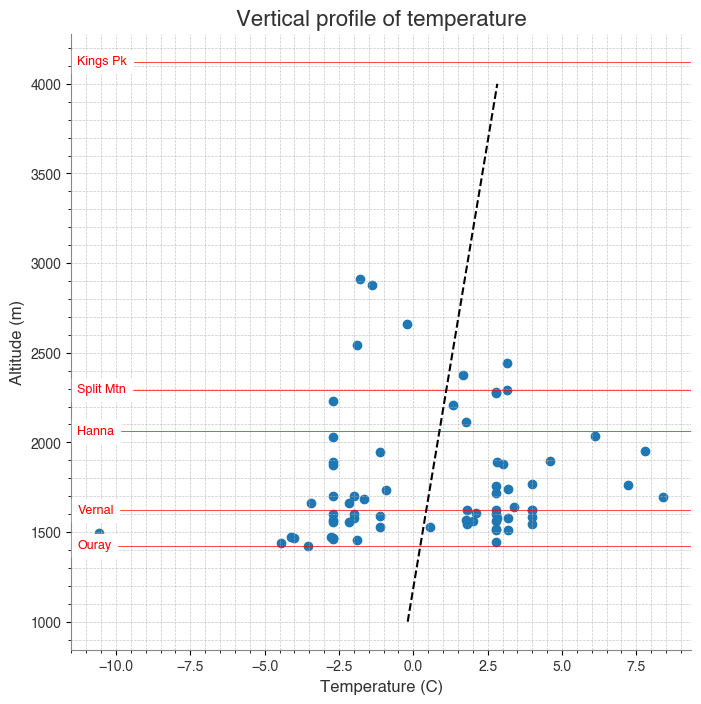

In [46]:
# With filtering at 1 standard dev
lapse_rate = compute_pseudo_lapse_rate(max_temp_20221201, elevations, do_filter=True, elev_bins=elev_bins, num_std_dev=1)

Pseudo-lapse rate: 2.25 °C/km


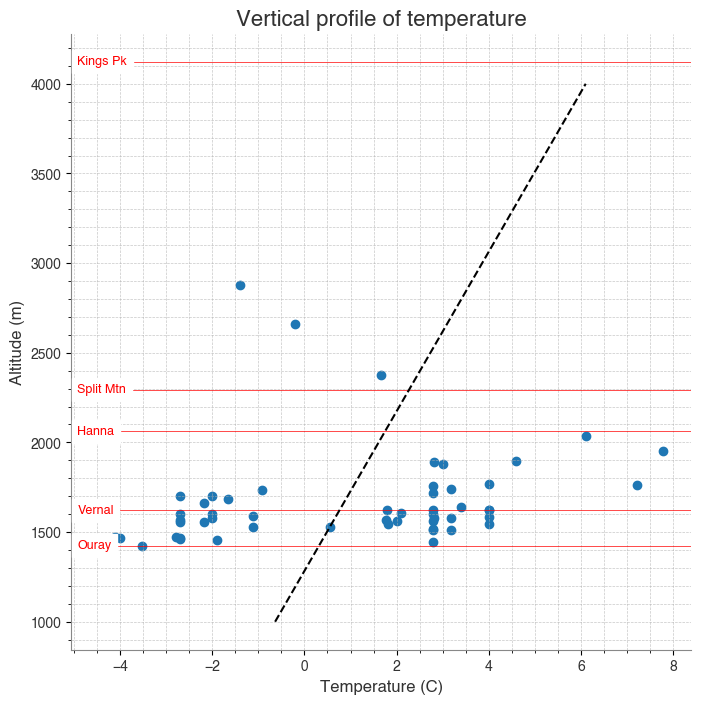

In [47]:
# With filtering at 0.5 standard dev
lapse_rate = compute_pseudo_lapse_rate(max_temp_20221201, elevations, do_filter=True, elev_bins=elev_bins, num_std_dev=0.5)

### Case studies 
We should identify longer periods of one continuous cold pool / ozone event in the five years we have good soil temperature data.
We want to look at pseudo-lapse-rate estimates and soil temperature in the Basin and whether they have predictive power for the FIS in Clyfar.

A catalogue of events would show the life cycle of the cold pool and high-ozone event: useful for the paper and FIS configuration.

Pseudo-lapse rate: 6.32 °C/km


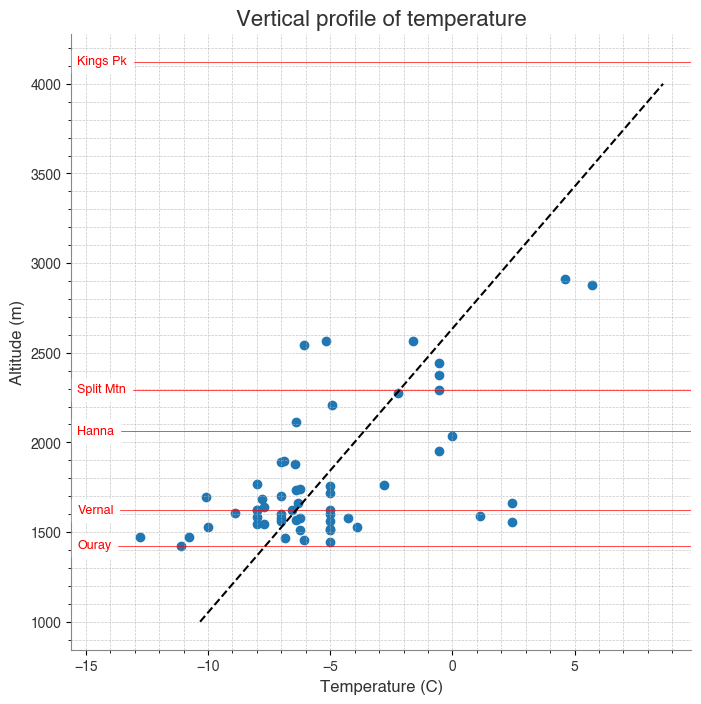

In [48]:
# Let's pick a day with high ozone to look at the inversion data 
case_study_date = "2023-02-10"
max_temp_casestudy = compute_max_temp_profile(common_temp_df, meta_df, case_study_date)
lapse_rate = compute_pseudo_lapse_rate(max_temp_casestudy, elevations, do_filter=True, elev_bins=elev_bins, num_std_dev=1.0)

Pseudo-lapse rate: -1.56 °C/km


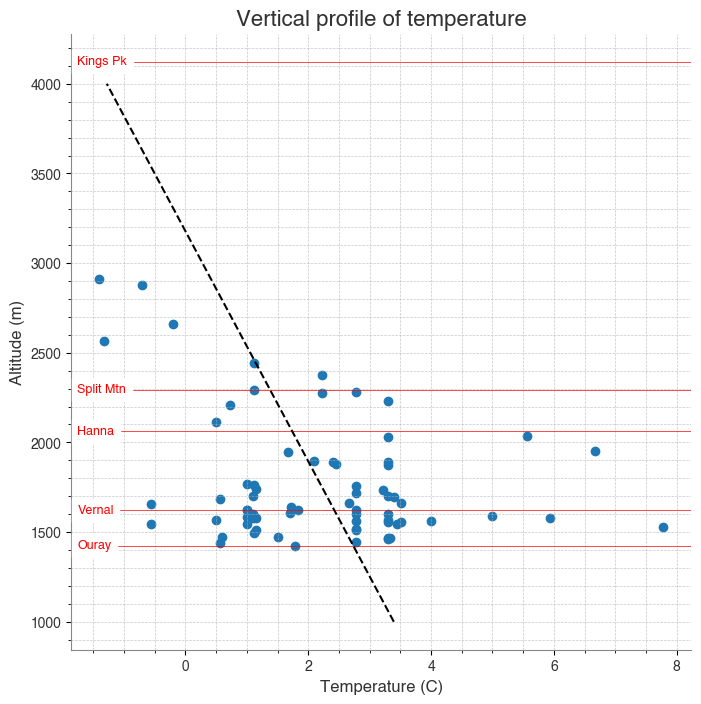

In [50]:
# Let's pick a day with low ozone to look at the inversion data 
case_study_date = "2023-01-01"
max_temp_casestudy = compute_max_temp_profile(common_temp_df, meta_df, case_study_date)
lapse_rate = compute_pseudo_lapse_rate(max_temp_casestudy, elevations, do_filter=True, elev_bins=elev_bins, num_std_dev=1.0)